# From Occasional to Steady: Habit Formation Insights From a Comprehensive Fitness Study

This is the notebook to generate the figures.

## Imports

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datetime import timedelta
from tqdm import tqdm
import copy
from sklearn.decomposition import NMF
import numpy as np

warnings.filterwarnings("ignore")

Below cell determines where the data to reproduce the figures is located. If you have the data in a different location, please change the path accordingly.

In [67]:
DATA_PREFIX = "./ens492-project-data/"

## 1. Figure 1

### 1.1 Figure 1(a)

In [68]:
members_df = pd.read_csv(DATA_PREFIX + "cstmr_june_22_dowhy.csv")
vst_df = pd.read_csv(DATA_PREFIX + "all_vsts_202401.csv")
cluster_6 = pd.read_csv(DATA_PREFIX + "users_clusters_6_weeks.csv")
cluster_17 = pd.read_csv(DATA_PREFIX + "users_clusters_17_weeks.csv")

Creating user patterns...


100%|██████████| 2407897/2407897 [00:38<00:00, 62684.11it/s]


User patterns created.
Preparing the dataframe...


100%|██████████| 199783/199783 [00:11<00:00, 17422.22it/s]


Dataframe ready.
NMF model working. This may take a while...
NMF model finished.


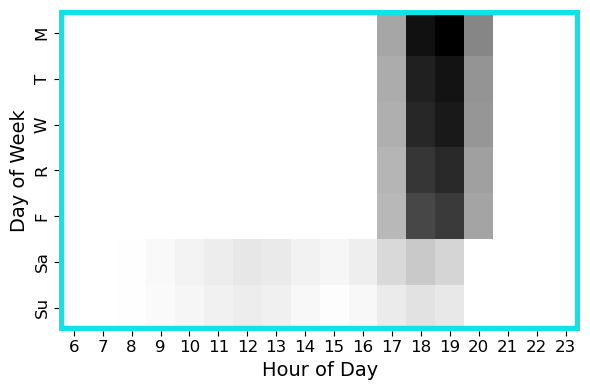

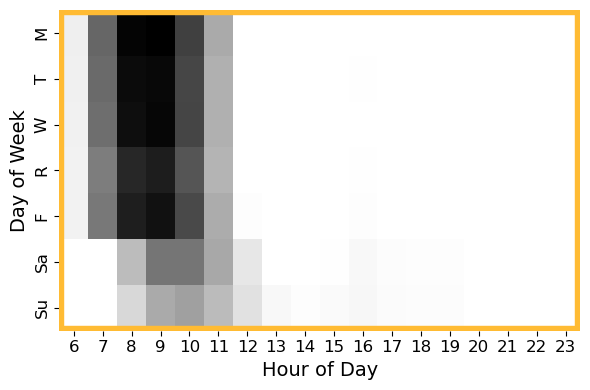

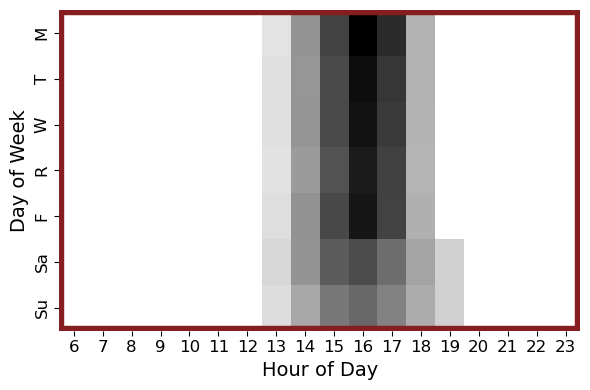

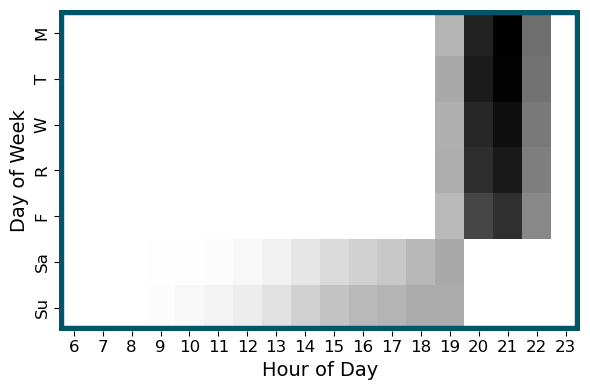

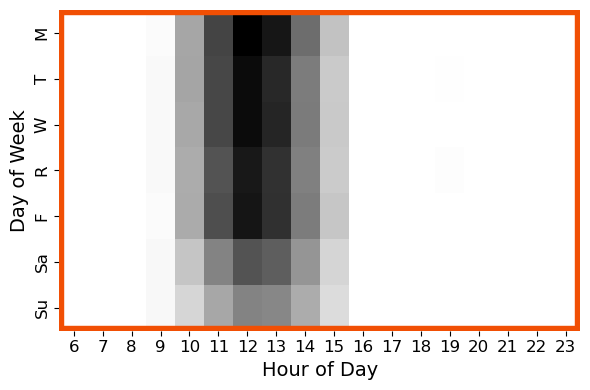

In [ ]:
vst_df = vst_df.merge(
    members_df[["USER_ID", "CONTRACT_START_DATE", "CONTRACT_END_DATE"]], on="USER_ID"
)

con1 = vst_df["CONTRACT_START_DATE"] <= vst_df["ENTER_DATE"]
con2 = vst_df["CONTRACT_END_DATE"] >= vst_df["LEAVE_DATE"]

vst_df = (
    vst_df[con1 & con2]
    .drop(columns=["CONTRACT_START_DATE", "CONTRACT_END_DATE"])
    .reset_index(drop=True)
)

users = list(members_df.USER_ID.unique())

vst_df = vst_df[vst_df["USER_ID"].isin(users)]

users = list(vst_df.USER_ID.unique())

members_df = members_df[members_df["USER_ID"].isin(users)]

vst_df = vst_df[vst_df["VISIT_DURATION"] <= 300]

members_df.dropna().reset_index(drop=True, inplace=True)
vst_df.dropna().reset_index(drop=True, inplace=True)

vst_df["ENTER_DATE"] = pd.to_datetime(vst_df["ENTER_DATE"])
vst_df["LEAVE_DATE"] = pd.to_datetime(vst_df["LEAVE_DATE"])
members_df["CONTRACT_START_DATE"] = pd.to_datetime(members_df["CONTRACT_START_DATE"])
members_df["CONTRACT_END_DATE"] = pd.to_datetime(members_df["CONTRACT_START_DATE"])

vst_df["ENTER_DATE_HOUR"] = vst_df["ENTER_DATE"].dt.hour
vst_df["LEAVE_DATE_HOUR"] = vst_df["LEAVE_DATE"].dt.hour
vst_df["ENTER_DATE_DOW"] = vst_df["ENTER_DATE"].dt.dayofweek


def is_weekend(dow):
    if dow == 5 or dow == 6:
        return 1
    return 0


vst_df["IS_WEEKEND"] = vst_df["ENTER_DATE_DOW"].apply(is_weekend)

first_week = (
    vst_df.groupby("USER_ID")["ENTER_DATE"]
    .min()
    .reset_index()
    .rename(columns={"ENTER_DATE": "FIRST_VST"})
)
first_week["FIRST_VST"] = pd.to_datetime(first_week["FIRST_VST"])
first_week["6_WEEKS"] = first_week["FIRST_VST"].dt.date + timedelta(days=6 * 7)
vst_df = vst_df.merge(first_week[["USER_ID", "6_WEEKS"]], on="USER_ID")

vst_df = vst_df[vst_df["ENTER_DATE"] <= vst_df["6_WEEKS"]]
members_df.shape, vst_df.shape
## User Matrixes
vst_df = vst_df[
    (vst_df["ENTER_DATE_HOUR"] >= 6) & (vst_df["LEAVE_DATE_HOUR"] <= 23)
].reset_index(drop=True)
# Template for hourly intervals
hour_temp = {f"{hour}:00-{hour+1}:00": 0 for hour in range(6, 24)}

# Template for weekdays with hourly intervals
hour_intervals_week_template = {day: hour_temp.copy() for day in range(7)}


def increment_user_daily_hourly_counts(user_data, entry_time, exit_time, enter_day):
    if enter_day in [5, 6]:
        for hour in range(entry_time, min(exit_time + 1, 20)):
            user_data[enter_day][f"{hour}:00-{hour+1}:00"] += 1
    else:
        for hour in range(entry_time, min(exit_time + 1, 23)):
            user_data[enter_day][f"{hour}:00-{hour+1}:00"] += 1


# Dictionary to hold each user's daily visit patterns
i = "./Users/"

vst_df_t = vst_df.copy()

# if not os.path.exists(i):
# os.makedirs(i)

user_patterns = {
    uid_clubid: copy.deepcopy(hour_intervals_week_template)
    for uid_clubid in vst_df_t["USER_ID"].unique()
}

# Apply the function to each record in the dataset
print("Creating user patterns...")
for _, row in tqdm(vst_df_t.iterrows(), total=len(vst_df_t)):
    user_id = row["USER_ID"]
    increment_user_daily_hourly_counts(
        user_patterns[user_id],
        row["ENTER_DATE_HOUR"],
        row["LEAVE_DATE_HOUR"],
        row["ENTER_DATE_DOW"],
    )
print("User patterns created.")

print("Preparing the dataframe...")
data_frames = []
for user_id, weekly_data in tqdm(user_patterns.items(), total=len(user_patterns)):
    for day, hours in weekly_data.items():
        for hour, count in hours.items():
            start_hour = int(hour.split(":")[0])  # Extracting the start hour
            data_frames.append(
                {
                    "USER_ID": user_id,
                    "Day": day,
                    "Start Hour": str(start_hour).zfill(2),
                    "Count": count,
                }
            )

df = pd.DataFrame(data_frames)
# df.to_csv(i + "dataframes_6_weeks.csv", index=False)
print("Dataframe ready.")

# df = pd.read_csv(i + "dataframes_6_weeks.csv")
df = df.sort_values(by="Start Hour")
df["Day_Hour"] = df["Day"].astype(str) + "_" + df["Start Hour"].astype(str)

# Pivot the DataFrame to get the desired matrix format
matrix_df = df.pivot_table(
    index="USER_ID", columns="Day_Hour", values="Count", fill_value=0
)

# matrix_df.to_csv(i + "matrix_df_6_weeks.csv", index=False)

# Apply NNMF
print("NMF model working. This may take a while...")
nmf_model = NMF(n_components=5, random_state=0, init="random")
W = nmf_model.fit_transform(matrix_df)
H = nmf_model.components_

H = H / max(H.flatten())

feature_patterns = pd.DataFrame(H, columns=matrix_df.columns)
# feature_patterns.to_csv(i + "feature_patterns_6_weeks.csv", index=False)

print("NMF model finished.")

colors = ["#ffbb33", "#f14f04", "#861d21", "#0fe3e6", "#005566"]
colors_new = [colors[3], colors[0], colors[2], colors[4], colors[1]]

for j in range(5):
    data = (
        pd.DataFrame(feature_patterns.iloc[j]).reset_index().rename(columns={j: "val"})
    )
    data[["Day", "Hour"]] = data["Day_Hour"].str.split("_", expand=True)

    # Convert 'Day' and 'Hour' to integers
    data["Day"] = data["Day"].astype(int)
    data["Hour"] = data["Hour"].astype(int)

    # Pivot the data to get the desired matrix format
    matrix_format = data.pivot(index="Day", columns="Hour", values="val")

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    sns.heatmap(matrix_format, ax=ax, cmap="binary", cbar=False)

    ax.set_yticklabels(["M", "T", "W", "R", "F", "Sa", "Su"])
    plt.ylabel("Day of Week", fontsize=14)
    plt.xlabel("Hour of Day", fontsize=14)

    ax.axhline(0, color=colors_new[j], linewidth=7.5)
    ax.axhline(matrix_format.shape[0], color=colors_new[j], linewidth=7.5)
    ax.axvline(0, color=colors_new[j], linewidth=7.5)
    ax.axvline(matrix_format.shape[1], color=colors_new[j], linewidth=7.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    # plt.savefig(i + f"user_daily_vst_patterns_cluster_{j}_6_weeks.png", dpi=1000)
    plt.show()
    plt.close()

Extract the data from the plots above.

In [ ]:
for j in range(5):
    data = (
        pd.DataFrame(feature_patterns.iloc[j]).reset_index().rename(columns={j: "val"})
    )
    data[["Day", "Hour"]] = data["Day_Hour"].str.split("_", expand=True)

    data["Day"] = data["Day"].astype(int)
    data["Hour"] = data["Hour"].astype(int)

    ds = ["M", "T", "W", "R", "F", "Sa", "Su"]
    translation = {i: ds[i] for i in range(len(ds))}

    data["Day"] = data["Day"].map(translation)
    data = data[["Day", "Hour", "val"]]
    data.rename(columns={"val": "Density", "Hour": "Hour of Day"}, inplace=True)
    data["Density"] = data["Density"] / np.sum(data["Density"])

    data.to_csv(i + f"6_weeks_cluster_{j}_day_hour_densities.csv", index=False)

### 1.2 Figure 1(b)

In [70]:
cstmr = members_df.copy()

In [71]:
cstmr["CLUSTER"] = cstmr[
    ["GECE_PROB", "SABAH_PROB", "AKSAM_PROB", "IKINDI_PROB", "OGLEN_PROB"]
].idxmax(axis=1)

column_label_mapping = {
    "GECE_PROB": "Night",
    "SABAH_PROB": "Morning",
    "AKSAM_PROB": "Evening",
    "IKINDI_PROB": "Afternoon",
    "OGLEN_PROB": "Noon",
}

cstmr["CLUSTER"] = cstmr["CLUSTER"].map(column_label_mapping)

In [72]:
cluster_gender_counts = cstmr.groupby(["CLUSTER", "SEX"]).size().unstack(fill_value=0)
cluster_totals = cluster_gender_counts.sum(axis=1)
cluster_gender_probs = cluster_gender_counts.div(cluster_totals, axis=0)

In [73]:
overall_gender_counts = cstmr["SEX"].value_counts()
total_counts = cstmr.shape[0]
overall_gender_probs = overall_gender_counts / total_counts

In [74]:
ratios = cluster_gender_probs.div(overall_gender_probs, axis=1)

In [75]:
ratios_transformed = ratios - 1.0

ratios_melted = ratios_transformed.reset_index().melt(
    id_vars="CLUSTER", var_name="Gender", value_name="Deviation"
)

ratios = ratios.reset_index().melt(
    id_vars="CLUSTER", var_name="Gender", value_name="Deviation"
)

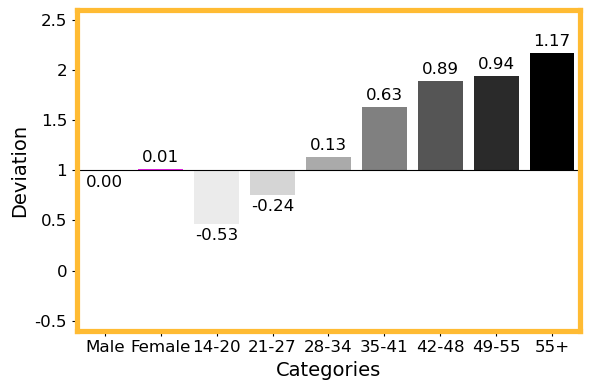

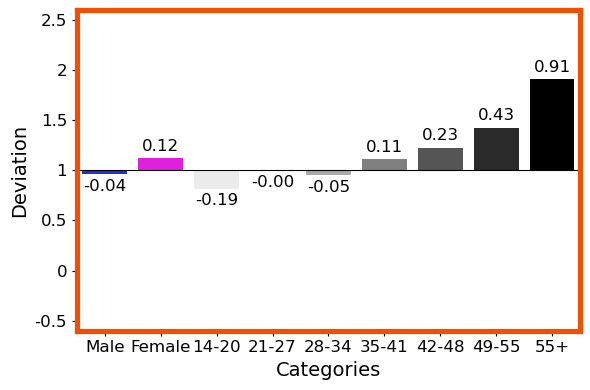

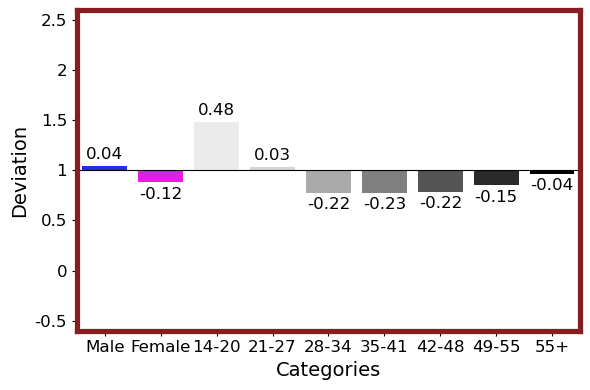

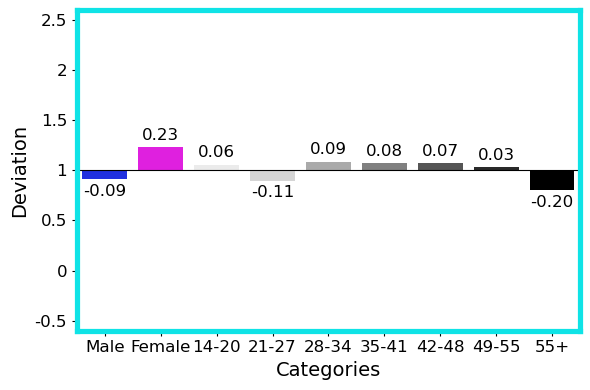

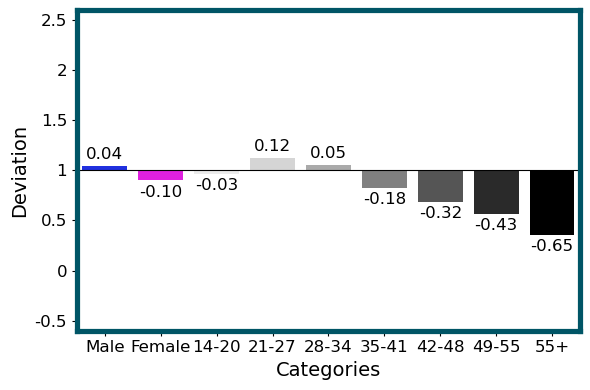

In [ ]:
age_category_totals = cstmr["AGE_CATEGORY"].value_counts(normalize=True)
cluster_order = ["Morning", "Noon", "Afternoon", "Evening", "Night"]
age_order = ["14-20", "21-27", "28-34", "35-41", "42-48", "49-55", "55+"]
gender_deviation = {
    "Morning": {"Female": 0.01, "Male": -0.00},
    "Noon": {"Female": 0.12, "Male": -0.04},
    "Afternoon": {"Female": -0.12, "Male": 0.04},
    "Evening": {"Female": 0.23, "Male": -0.09},
    "Night": {"Female": -0.10, "Male": 0.04},
}

ax_colors = ["#ffbb33", "#f14f04", "#861d21", "#0fe3e6", "#005566"]

colors = [
    "#0015FF",
    "#FF00FF",
    "#EBEBEB",
    "#D5D5D5",
    "#AAAAAA",
    "#808080",
    "#555555",
    "#2A2A2A",
    "#000000",
]

for i, cluster in enumerate(cluster_order):
    cluster_data = cstmr[cstmr["CLUSTER"] == cluster]
    gender_counts = pd.DataFrame(
        [
            {
                "Category": "Female",
                "Count": gender_deviation[cluster]["Female"],
                "Type": "Gender",
            },
            {
                "Category": "Male",
                "Count": gender_deviation[cluster]["Male"],
                "Type": "Gender",
            },
        ]
    )

    # age category calculation
    age_counts = cluster_data["AGE_CATEGORY"].value_counts(normalize=True).reset_index()
    age_counts.columns = ["Category", "Count"]
    age_counts["Count"] = age_counts.apply(
        lambda row: row["Count"] / age_category_totals[row["Category"]] - 1, axis=1
    )
    age_counts["Type"] = "Age Category"

    combined_counts = pd.concat([gender_counts, age_counts])

    """combined_counts[["Category", "Count"]].to_csv(
        i + f"6_weeks_{cluster.lower()}_cluster_deviations_from_average.csv", index=False
    )"""

    plt.figure(figsize=(6, 4))
    barplot = sns.barplot(
        data=combined_counts,
        x="Category",
        y="Count",
        order=["Male", "Female"] + age_order,
        palette=colors,
    )
    # plt.title(f'{cluster} - Gender and Age Category Distribution')
    plt.ylabel("Deviation", fontsize=14)
    plt.xlabel("Categories", fontsize=14)
    plt.xticks(fontsize=12)

    plt.yticks(fontsize=12)
    plt.axhline(0, color="black", linestyle="-", linewidth=0.8)
    max_y = combined_counts["Count"].abs().max()
    plt.ylim(-1.6, 1.6)
    barplot.set_yticklabels([-1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5])

    # Annotate the bars with their values
    for p in barplot.patches:
        height = p.get_height()
        barplot.annotate(
            format(height, ".2f"),
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="bottom" if height > 0 else "top",
            xytext=(0, 3) if height > 0 else (0, -3),
            textcoords="offset points",
            fontsize=12,
        )
    for spine in barplot.spines.values():
        spine.set_edgecolor(ax_colors[i])
        spine.set_linewidth(3.75)

    plt.tight_layout()
    plt.show()
    # plt.savefig(i + f"cluster_analysis/deviations_{cluster.lower()}.png", dpi=1000)
    plt.close()

### Fig 1(c, d, e)

In [77]:
clusters = cluster_6.merge(cluster_17, on="USER_ID", suffixes=["_6", "_17"])

In [78]:
clusters["CLUSTER_6"] = clusters[
    ["GECE_PROB_6", "SABAH_PROB_6", "AKSAM_PROB_6", "IKINDI_PROB_6", "OGLEN_PROB_6"]
].idxmax(axis=1)

column_label_mapping = {
    "GECE_PROB_6": "Night",
    "SABAH_PROB_6": "Morning",
    "AKSAM_PROB_6": "Evening",
    "IKINDI_PROB_6": "Afternoon",
    "OGLEN_PROB_6": "Noon",
}

# Apply the mapping to the new column
clusters["CLUSTER_6"] = clusters["CLUSTER_6"].map(column_label_mapping)

clusters["CLUSTER_17"] = clusters[
    [
        "GECE_PROB_17",
        "SABAH_PROB_17",
        "AKSAM_PROB_17",
        "IKINDI_PROB_17",
        "OGLEN_PROB_17",
    ]
].idxmax(axis=1)

column_label_mapping = {
    "GECE_PROB_17": "Night",
    "SABAH_PROB_17": "Morning",
    "AKSAM_PROB_17": "Evening",
    "IKINDI_PROB_17": "Afternoon",
    "OGLEN_PROB_17": "Noon",
}

# Apply the mapping to the new column
clusters["CLUSTER_17"] = clusters["CLUSTER_17"].map(column_label_mapping)

In [79]:
colors = ["#ffbb33", "#f14f04", "#861d21", "#0fe3e6", "#005566"]
order = ["Morning", "Noon", "Afternoon", "Evening", "Night"]

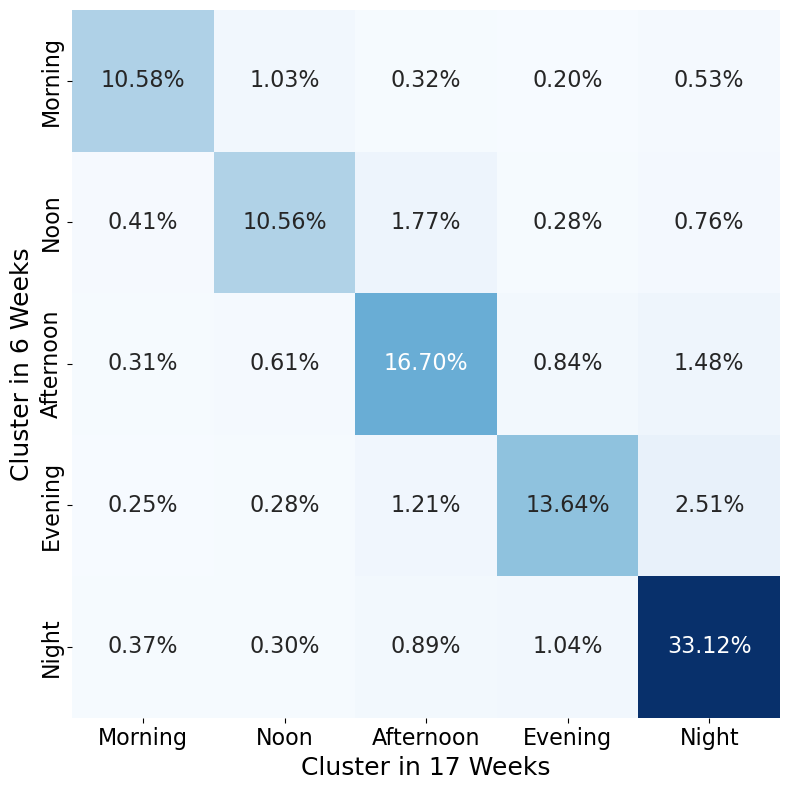

In [ ]:
# Assuming clusters and order are already defined
transition_matrix = pd.crosstab(
    clusters["CLUSTER_6"],
    clusters["CLUSTER_17"],
    rownames=["CLUSTER_6"],
    colnames=["CLUSTER_17"],
)
transition_matrix = transition_matrix.reindex(order)[order]

# Normalize the transition matrix
transition_matrix = transition_matrix / transition_matrix.sum().sum()

plt.figure(figsize=(8, 8))
sns.heatmap(
    transition_matrix,
    annot=True,
    fmt=".2%",
    cmap="Blues",
    vmax=0.33,
    vmin=0,
    cbar=False,
    square=True,
    annot_kws={"size": 16},
)
plt.ylabel("Cluster in 6 Weeks", fontsize=18)
plt.xlabel("Cluster in 17 Weeks", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()
# plt.savefig(i + "cluster_analysis/cluster_transition_matrix.png", dpi=1000)
plt.close()

In [ ]:
transitions = transition_matrix.unstack().reset_index()

transitions.columns = ["17 Weeks Cluster", "6 Weeks Cluster", "Percentage of Users"]

transitions = transitions[
    ["6 Weeks Cluster", "17 Weeks Cluster", "Percentage of Users"]
]

transitions.to_csv(i + "6_weeks_17_weeks_cluster_transitions.csv", index=False)

In [81]:
# Calculate the total number of people who did not change clusters
unchanged_clusters = transition_matrix.values.diagonal().sum()

# Calculate the total number of people
total_instances = transition_matrix.values.sum()

# Calculate the percentage of people who did not change clusters
percentage_unchanged = (unchanged_clusters / total_instances) * 100

print(
    f"Percentage of people with unchanged clusters: {round(percentage_unchanged, 4)}%"
)

Percentage of people with unchanged clusters: 84.6048%


In [82]:
clusters["6_MAX"] = clusters[
    ["GECE_PROB_6", "SABAH_PROB_6", "AKSAM_PROB_6", "IKINDI_PROB_6", "OGLEN_PROB_6"]
].max(axis=1)
clusters["17_MAX"] = clusters[
    [
        "GECE_PROB_17",
        "SABAH_PROB_17",
        "AKSAM_PROB_17",
        "IKINDI_PROB_17",
        "OGLEN_PROB_17",
    ]
].max(axis=1)

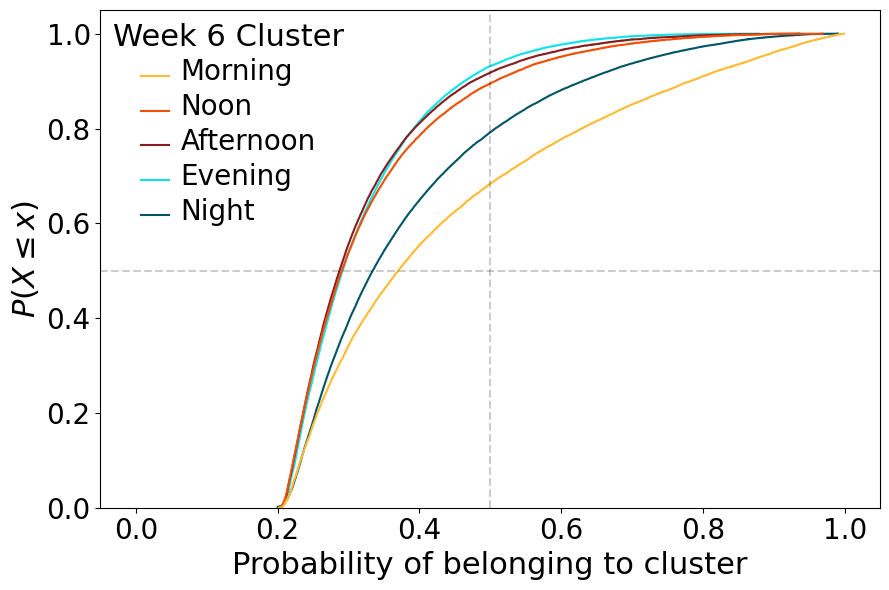

In [ ]:
# Assuming clusters, order, and colors are already defined
plt.figure(figsize=(9, 6))
p = sns.ecdfplot(
    data=clusters,
    x="6_MAX",
    stat="proportion",
    hue="CLUSTER_6",
    hue_order=order,
    palette=colors,
)
legend = p.get_legend()
legend.set_title("Week 6 Cluster")
legend.set_frame_on(False)  # Remove the border box from the legend

# Increase the font size in the legend
for text in legend.get_texts():
    text.set_fontsize(20)
legend.get_title().set_fontsize(22)

plt.xlabel("Probability of belonging to cluster", fontsize=22)
plt.ylabel("$P(X \leq x)$", fontsize=22)
plt.ylim(0, 1.05)
plt.xlim(-0.05, 1.05)
plt.axhline(0.5, linestyle="--", color="black", alpha=0.2)
plt.axvline(0.5, linestyle="--", color="black", alpha=0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig(i + "cluster_analysis/week_6_combined_cdf.png", dpi=1000)
plt.close()

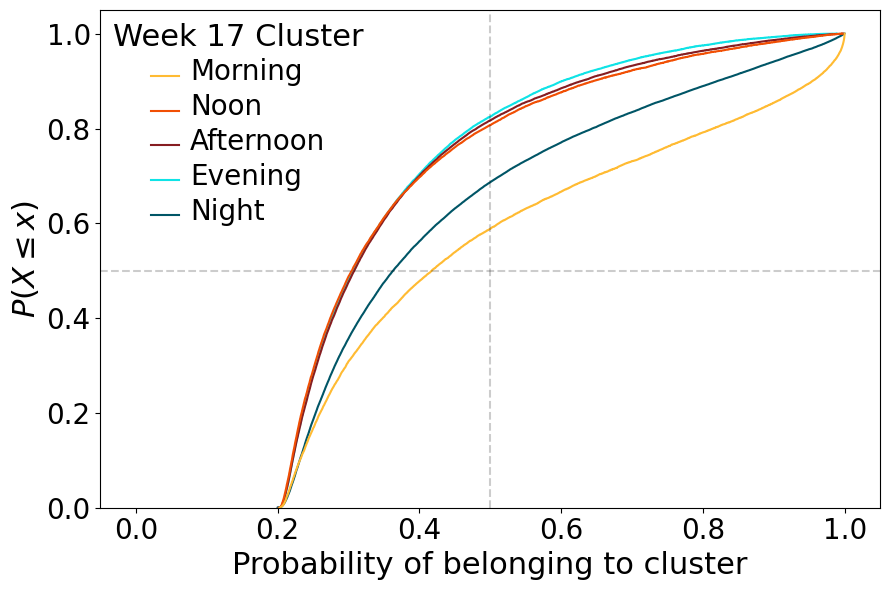

In [ ]:
# Assuming clusters, order, and colors are already defined
plt.figure(figsize=(9, 6))
p = sns.ecdfplot(
    data=clusters,
    x="17_MAX",
    stat="proportion",
    hue="CLUSTER_17",
    hue_order=order,
    palette=colors,
)
legend = p.get_legend()
legend.set_title("Week 17 Cluster")
legend.set_frame_on(False)  # Remove the border box from the legend

# Increase the font size in the legend
for text in legend.get_texts():
    text.set_fontsize(20)
legend.get_title().set_fontsize(22)

plt.xlabel("Probability of belonging to cluster", fontsize=22)
plt.ylabel("$P(X \leq x)$", fontsize=22)
plt.ylim(0, 1.05)
plt.xlim(-0.05, 1.05)
plt.axhline(0.5, linestyle="--", color="black", alpha=0.2)
plt.axvline(0.5, linestyle="--", color="black", alpha=0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig(i + "cluster_analysis/week_17_combined_cdf.png", dpi=1000)
plt.close()

## Figure 2

In [13]:
DATA_PREFIX = "/Users/ahmetfurkanun/Downloads/"
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

In [15]:
cstmr = pd.read_csv(DATA_PREFIX + "cstmr_june_22_dowhy.csv", low_memory=False)

# Define columns representing probability distributions over different CLUSTERS
columns_of_interest = ['GECE_PROB', 'SABAH_PROB', 'AKSAM_PROB', 'IKINDI_PROB', 'OGLEN_PROB']

# Assign each customer to the CLUSTER with the highest probability
cstmr['CLUSTER'] = cstmr[columns_of_interest].idxmax(axis=1)

# Map column names to labels
column_label_mapping = {
    'GECE_PROB': 'Night',
    'SABAH_PROB': 'Morning',
    'AKSAM_PROB': 'Evening',
    'IKINDI_PROB': 'Afternoon',
    'OGLEN_PROB': 'Noon'
}
cstmr['CLUSTER'] = cstmr['CLUSTER'].map(column_label_mapping)

# Define date range for analysis
start_date = datetime(2022, 1, 1)
end_date = datetime(2024, 1, 31)
date_range = pd.date_range(start=start_date, end=end_date)
week = pd.DataFrame({'date': date_range})
week['Week_Number'] = ((week['date'] - start_date).dt.days // 7 + 1).astype(int)

# Load visit data
vst = pd.read_csv(DATA_PREFIX + "all_vsts_202401.csv")
vst["ENTER_DATE"] = pd.to_datetime(vst["ENTER_DATE"])
vst = vst.sort_values(["USER_ID", "ENTER_DATE"])

# Merge with customer contract dates
vst = vst.merge(cstmr[["USER_ID", "CONTRACT_START_DATE", "CONTRACT_END_DATE"]], on="USER_ID")

# Filter visits within contract period
vst_new = vst[(vst["ENTER_DATE"] >= vst["CONTRACT_START_DATE"]) & (vst["ENTER_DATE"] <= vst["CONTRACT_END_DATE"])]
vst_new['ENTER_DATE'] = vst_new['ENTER_DATE'].dt.date
vst_new = vst_new[["USER_ID", "ENTER_DATE"]].drop_duplicates()
vst_new['ENTER_DATE'] = pd.to_datetime(vst_new['ENTER_DATE'])

# Create a dimension table with all user-week combinations
dimension = pd.DataFrame(vst_new["USER_ID"].unique(), columns=["USER_ID"])
dimension = dimension.merge(pd.DataFrame(week["Week_Number"].unique(), columns=["Week_Number"]), how="cross")

# Determine the first visit week per user
first_visit_week = vst_new.merge(week, left_on="ENTER_DATE", right_on="date", how="outer")
first_visit_week = first_visit_week.groupby("USER_ID")["Week_Number"].min().reset_index()
first_visit_week.columns = ["USER_ID", "first_visit_week"]

# Aggregate weekly visit counts
weekly = vst_new.merge(week, left_on="ENTER_DATE", right_on="date", how="outer")
weekly = weekly.groupby(["USER_ID", "Week_Number"]).count().reset_index()
weekly = weekly.merge(dimension, on=["USER_ID", "Week_Number"], how="right").fillna(0)
weekly = weekly.merge(first_visit_week, on="USER_ID")
weekly = weekly.rename(columns={"ENTER_DATE": "VST_COUNT"})

# Retain only data after the user's first visit week
weekly = weekly[weekly["first_visit_week"] <= weekly["Week_Number"]]

# Initialize summary DataFrame
summary_df = cstmr[["USER_ID"]]

# Aggregate visit counts for each week (up to 52 weeks)
for i in tqdm(range(1, 53)):
    temp = weekly[weekly["Week_Number"] == weekly["first_visit_week"] + i - 1]
    temp = temp.groupby("USER_ID")["VST_COUNT"].sum().reset_index()
    temp.rename(columns={"VST_COUNT": f"VISITS_IN_WEEK_{i}"}, inplace=True)
    summary_df = summary_df.merge(temp, on="USER_ID", how="left")

# Assign survival grace period
target_weeks = 52
summary_df['0_WEEKS_SURVIVAL_GRACE_DAY'] = cstmr['0_WEEKS_SURVIVAL_GRACE_DAY']

# Compute total gaps per user
gaps_per_user = []
visit_columns = [col for col in summary_df.columns if col.startswith('VISITS_IN_WEEK') and int(col.split('_')[-1]) <= target_weeks]

for index, row in summary_df.iterrows():
    visits = row[visit_columns].values
    survival = row['0_WEEKS_SURVIVAL_GRACE_DAY']
    total_gaps = 0
    
    for week in range(1, len(visits) - 1):
        # Identify gaps (a zero visit count between two non-zero weeks)
        if visits[week] == 0 and visits[week - 1] > 0 and visits[week + 1] > 0:
            if week <= survival:
                total_gaps += 1
    
    gaps_per_user.append(total_gaps)

# Store total gaps in summary DataFrame
summary_df['total_gaps'] = gaps_per_user

/var/folders/8w/nptdlxfd2bd98ccgggpzzbm80000gn/T/ipykernel_99476/1603754830.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vst_new['ENTER_DATE'] = vst_new['ENTER_DATE'].dt.date
100%|███████████████████████████████████████████| 52/52 [00:04<00:00, 11.53it/s]


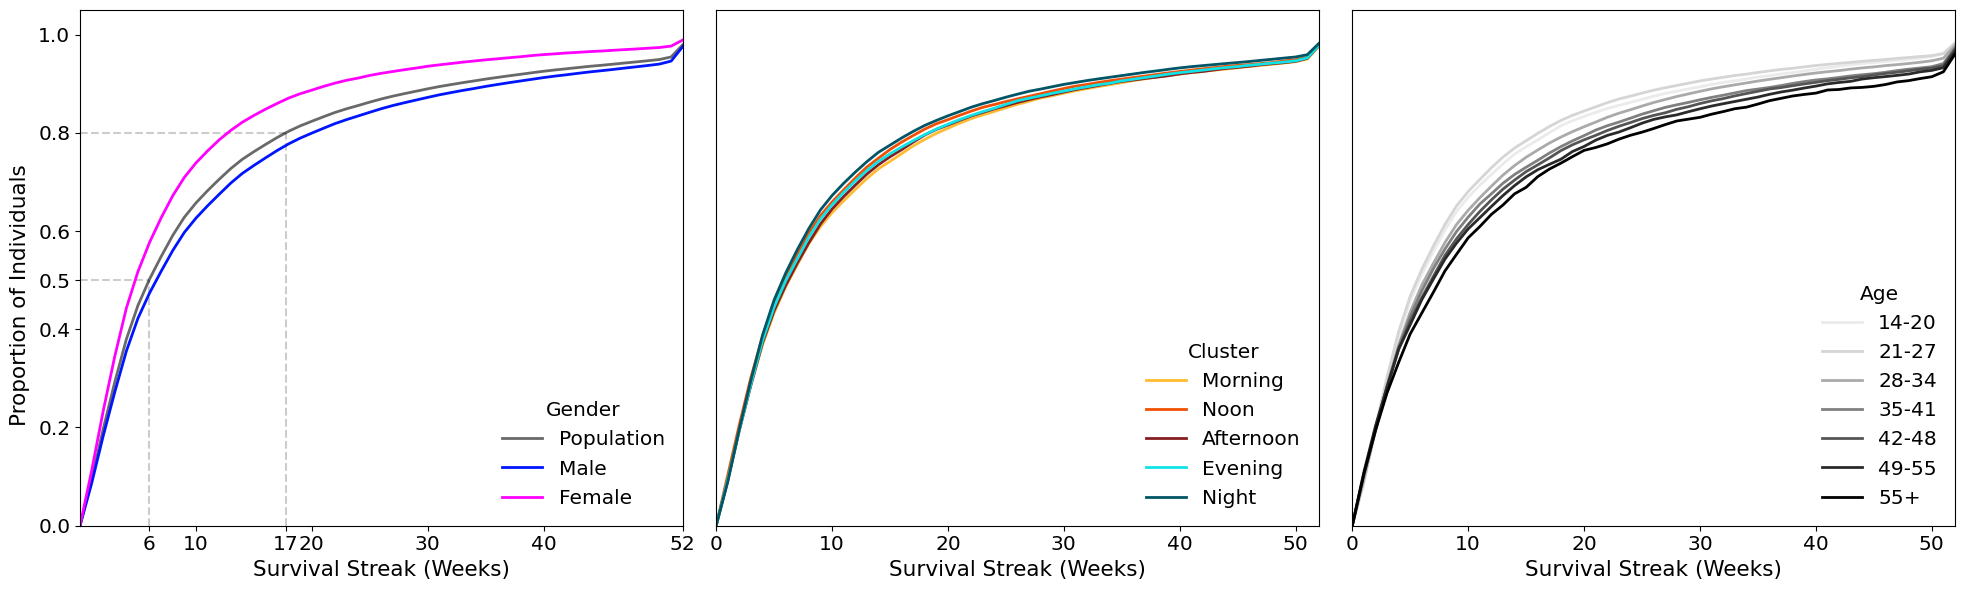

In [45]:
def find_val(x_fit, y_fit, val):
    index = np.where(y_fit >= val)[0]
    return x_fit[index[0]] if index.size > 0 else None

# Create a figure with 1x3 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Plot 3
total_people = len(cstmr)
xs = []
ys = []
for j in range(53):
    temp = cstmr[cstmr["0_WEEKS_SURVIVAL_GRACE_DAY"] <= j]
    xs.append(j)
    ys.append(len(temp) / total_people)

axs[0].plot(xs, ys, color='dimgray', linewidth=2, label="Population")

# Polynomial fit and critical points
z = np.polyfit(xs, ys, 25)
p = np.poly1d(z)
x = np.linspace(1, 53, 1000000)
y = p(x)

prob_x = find_val(x, y, 0.5)
prob_x_2 = find_val(x, y, 0.8)

axs[0].plot([prob_x, prob_x], [0, 0.5], linestyle="--", color="black", alpha=0.2)
axs[0].plot([0, prob_x], [0.5, 0.5], linestyle="--", color="black", alpha=0.2)

axs[0].plot([prob_x_2, prob_x_2], [0, 0.8], linestyle="--", color="black", alpha=0.2)
axs[0].plot([0, prob_x_2], [0.8, 0.8], linestyle="--", color="black", alpha=0.2)

gender_colors = ["#0015FF", "#FF00FF"]
for i, cluster in enumerate(["Male", "Female"]):
    xs = []
    ys = []
    subset = cstmr[cstmr['SEX'] == cluster]
    total_people_cluster = len(subset)
    for j in range(53):
        temp = subset[subset["0_WEEKS_SURVIVAL_GRACE_DAY"] <= j]
        xs.append(j)
        ys.append(len(temp) / total_people_cluster)
    axs[0].plot(xs, ys, label=cluster, color=gender_colors[i], linewidth=2)

axs[0].set_xticks([prob_x, 10, prob_x_2, 20, 30, 40, 52])
axs[0].set_xticklabels(["6", "10", "17", "20", "30", "40", "52"])
axs[0].set_yticks([0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0])
axs[0].set_xlabel('Survival Streak (Weeks)', fontsize=15.5)
axs[0].set_ylim(0, 1.05)
axs[0].set_xlim(0, 52)
axs[0].xaxis.set_tick_params(labelsize=14.5)
axs[0].yaxis.set_tick_params(labelsize=14.5)
axs[0].legend(fontsize=14.5, title="Gender", title_fontsize=14.5, frameon=False, loc='lower right')

# Plot 4
colors = ["#ffbb33", "#f14f04", "#861d21", "#0fe3e6", "#005566"]
for i, cluster in enumerate(['Morning', 'Noon', 'Afternoon', 'Evening', 'Night']):
    xs = []
    ys = []
    subset = cstmr[cstmr['CLUSTER'] == cluster]
    total_people_cluster = len(subset)
    for j in range(53):
        temp = subset[subset["0_WEEKS_SURVIVAL_GRACE_DAY"] <= j]
        xs.append(j)
        ys.append(len(temp) / total_people_cluster)
    axs[1].plot(xs, ys, label=cluster, color=colors[i], linewidth=2)

axs[1].legend(fontsize=14.5, title="Cluster", title_fontsize=14.5, frameon=False, loc='lower right')
axs[1].set_xlabel('Survival Streak (Weeks)', fontsize=15.5)
axs[1].set_xlim(0, 52)
axs[1].set_ylim(0, 1.05)
axs[1].yaxis.set_visible(False)
axs[1].xaxis.set_tick_params(labelsize=14.5)

# Plot 6
age_colors = ["#EBEBEB", "#D5D5D5", "#AAAAAA", "#808080", "#555555", "#2A2A2A", "#000000"]
for i, cluster in enumerate(['14-20', '21-27', '28-34', '35-41', '42-48', '49-55', '55+']):
    xs = []
    ys = []
    subset = cstmr[cstmr['AGE_CATEGORY'] == cluster]
    total_people_cluster = len(subset)
    for j in range(53):
        temp = subset[subset["0_WEEKS_SURVIVAL_GRACE_DAY"] <= j]
        xs.append(j)
        ys.append(len(temp) / total_people_cluster)
    axs[2].plot(xs, ys, label=cluster, color=age_colors[i], linewidth=2)

axs[2].legend(fontsize=14.5, title="Age", title_fontsize=14.5, frameon=False, loc='lower right')
axs[2].yaxis.set_visible(False)
axs[2].set_xlabel('Survival Streak (Weeks)', fontsize=15.5)
axs[2].set_xlim(0, 52)
axs[2].set_ylim(0, 1.05)
axs[2].xaxis.set_tick_params(labelsize=14.5)
axs[2].yaxis.set_tick_params(labelsize=14.5)

# Adjust layout to prevent overlapping
plt.tight_layout() 

# Adjust the padding for the ylabel
fig.subplots_adjust(left=0.055)

# Shared labels
fig.supylabel('Proportion of Individuals', fontsize=15.5)

# Save and show the plot
#plt.savefig("Fig_2_Cumulative_dist_of_the_survival_streaks.png", dpi=350)
plt.show()

## Figure 3

### Figure 3(a)

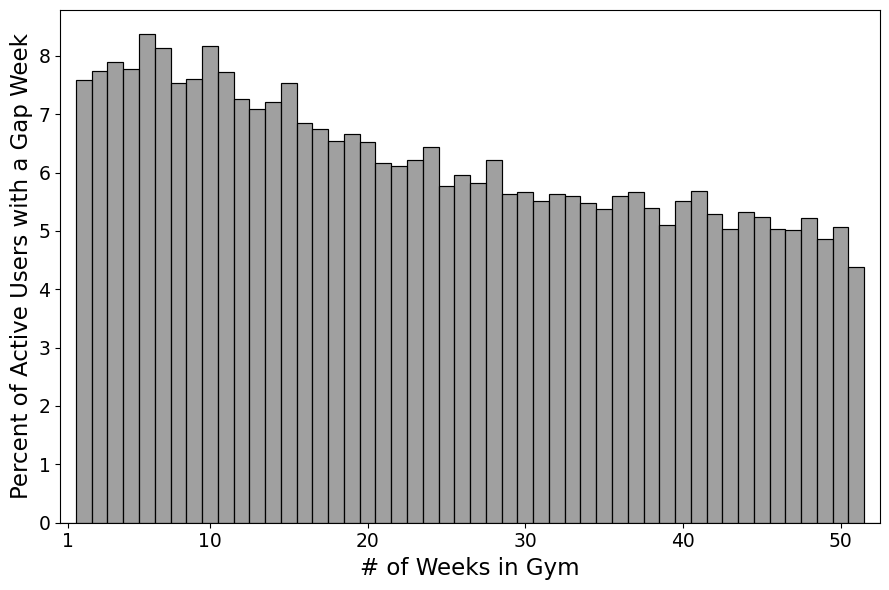

In [47]:
# Identify columns corresponding to weekly visit data
visit_columns = [col for col in summary_df.columns if col.startswith('VISITS_IN_WEEK')]

# Initialize an array to store the number of 1-week gaps per week
gaps_per_week = np.zeros(len(visit_columns) - 1)

# Count 1-week gaps for each user
for _, row in summary_df.iterrows():
    visits = row[visit_columns].values
    survival = row['0_WEEKS_SURVIVAL_GRACE_DAY']
    for week in range(1, len(visits) - 1):
        if visits[week] == 0 and visits[week - 1] > 0 and visits[week + 1] > 0:
            if week <= survival:
                gaps_per_week[week] += 1

# Compute total active users per week
active_users_per_week = [len(cstmr[cstmr["0_WEEKS_SURVIVAL_GRACE_DAY"] >= i]) for i in range(1, 52)]

# Calculate percentage of active users with a 1-week gap
gaps_per_week_x = np.arange(1, len(gaps_per_week) + 1)
gaps_per_week_y = (gaps_per_week / active_users_per_week) * 100  # Convert to percentage

# Plot the percentage of active users with a 1-week gap
plt.figure(figsize=(9, 6))
sns.histplot(x=gaps_per_week_x, weights=gaps_per_week_y, bins=list(np.arange(0, 54) - 0.5), kde=False, color='gray')

# Configure plot appearance
font_size = 16.5
plt.xlabel('# of Weeks in Gym', fontsize=font_size)
plt.ylabel('Percent of Active Users with a Gap Week', fontsize=font_size)
plt.xticks([1, 10, 20, 30, 40, 50], fontsize=font_size - 3)
plt.yticks(fontsize=font_size - 3)
plt.xlim(0.5, 52.5)

# Adjust layout and display the plot
plt.tight_layout()
#plt.savefig("Fig_3_a_gap_week_statistics.png", dpi=350)
plt.show()

# Export aggregated data
aggregated_data = pd.DataFrame({
    'Week': gaps_per_week_x,
    'Percent_Users_with_Gap': gaps_per_week_y
})
aggregated_data.to_csv("Figures Data/Fig_3_a_gap_week_statistics.csv", index=False)

### Figure 3(b)

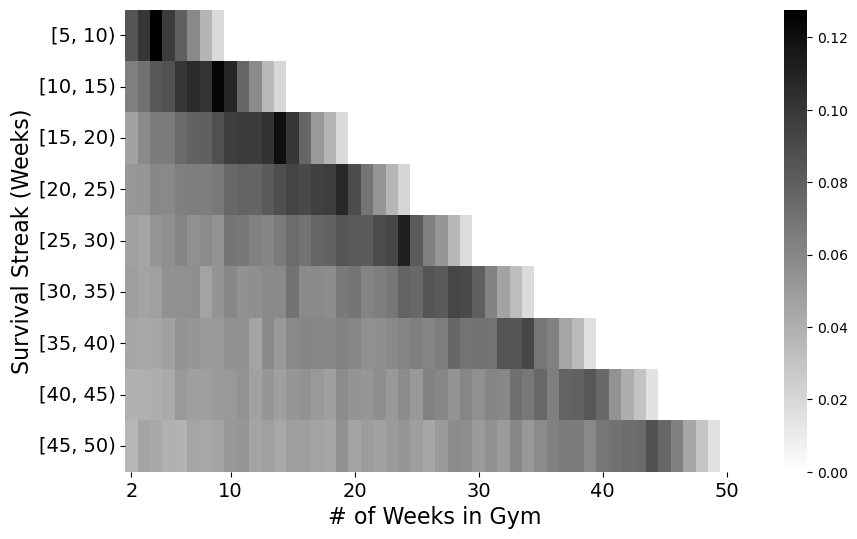

In [49]:
# Define survival streak intervals for analysis
survival_thresholds = [i * 5 for i in range(1, 10)]

# Initialize a list to store the proportion of gaps for each subgroup
gaps_proportions = []

# Compute weekly gap proportions for different survival streak subgroups
for threshold in survival_thresholds:
    # Filter data for users within the survival streak range
    subgroup_df = summary_df[(summary_df['0_WEEKS_SURVIVAL_GRACE_DAY'] < threshold + 5) &
                             (summary_df['0_WEEKS_SURVIVAL_GRACE_DAY'] >= threshold)]
    
    # Initialize an array to track the number of one-week gaps per week
    gaps_per_week = np.zeros(len(visit_columns) - 1)
    
    # Iterate through each user in the subgroup to count one-week gaps
    for _, row in subgroup_df.iterrows():
        visits = row[visit_columns].values
        for week in range(1, len(visits) - 1):
            if visits[week] == 0 and visits[week - 1] > 0 and visits[week + 1] > 0:
                if week <= row['0_WEEKS_SURVIVAL_GRACE_DAY']:
                    gaps_per_week[week] += 1
    
    # Calculate the proportion of users experiencing a one-week gap per week
    gaps_proportion = gaps_per_week / len(subgroup_df) if len(subgroup_df) > 0 else np.zeros(len(gaps_per_week))
    gaps_proportions.append(gaps_proportion)

# Convert the list of gap proportions into a NumPy array for visualization
gaps_proportions_array = np.array(gaps_proportions)

# Generate heatmap visualization
plt.figure(figsize=(10, 6))
sns.heatmap(gaps_proportions_array, cmap='binary',
            yticklabels=[f'[{thr}, {thr+5})' for thr in survival_thresholds])
plt.xlim(left=1)
plt.yticks(fontsize=14)
plt.xticks([1.5, 9.5, 19.5, 29.5, 39.5, 49.5], labels=[2, 10, 20, 30, 40, 50], fontsize=14)
plt.xlabel('# of Weeks in Gym', fontsize=16)
plt.ylabel('Survival Streak (Weeks)', fontsize=16)
#plt.savefig("Fig_3_b_gap_week_heatmap_data.png", dpi=350)
plt.show()

# Save aggregated
export_data = pd.DataFrame(gaps_proportions_array, 
                           index=[f'[{thr}, {thr+5})' for thr in survival_thresholds],
                           columns=[f'Week {i+1}' for i in range(gaps_proportions_array.shape[1])])
export_data.to_csv("Figures Data/Fig_3_b_gap_week_heatmap_data.csv", index=True)

### Figure 3(c)

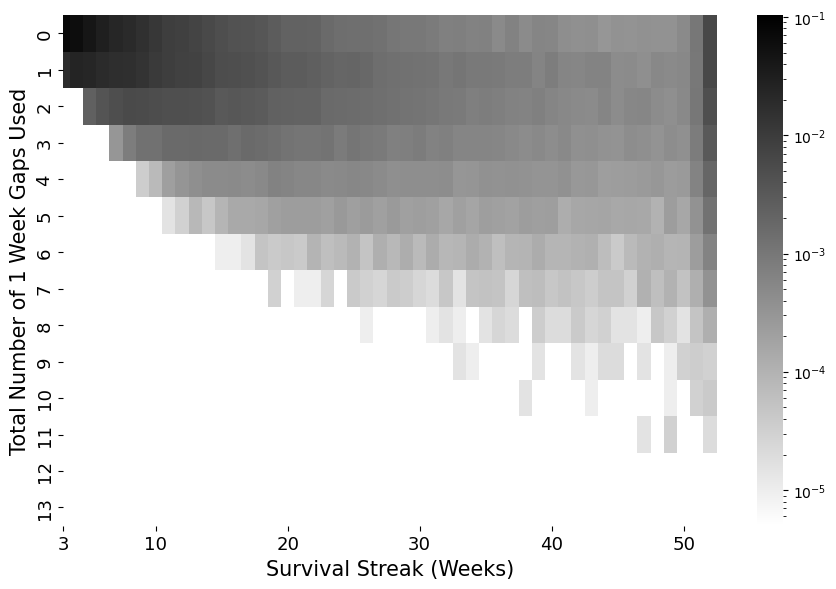

In [23]:
import matplotlib.colors as mcolors

# Create the pivot table
heatmap_data = summary_df[summary_df['0_WEEKS_SURVIVAL_GRACE_DAY'] <=52].pivot_table(index='total_gaps', columns='0_WEEKS_SURVIVAL_GRACE_DAY', fill_value = 0, aggfunc='size')
heatmap_data = heatmap_data / len(summary_df)
font = 15

# Plot the heatmap
plt.figure(figsize=(9, 6))
ax = sns.heatmap(heatmap_data, cmap="binary", fmt="d", norm=mcolors.LogNorm())
plt.xlabel('Survival Streak (Weeks)',fontsize=font)
plt.xlim(3, 52)
plt.ylabel('Total Number of 1 Week Gaps Used', fontsize=font)
plt.yticks(fontsize=font-2)
plt.xticks([2.5, 9.5, 19.5, 29.5, 39.5, 49.5], [3, 10, 20, 30, 40, 50],fontsize=font-2)
plt.tight_layout()
plt.savefig("Fig_3_c_total_gaps_heatmap_data.png", dpi=350)
plt.show()

#Export Plot Data
heatmap_data.to_csv("Figures Data/Fig_3_c_total_gaps_heatmap_data.csv", index=True)

### Figure 3(d)

100%|███████████████████████████████████████████| 47/47 [03:26<00:00,  4.40s/it]


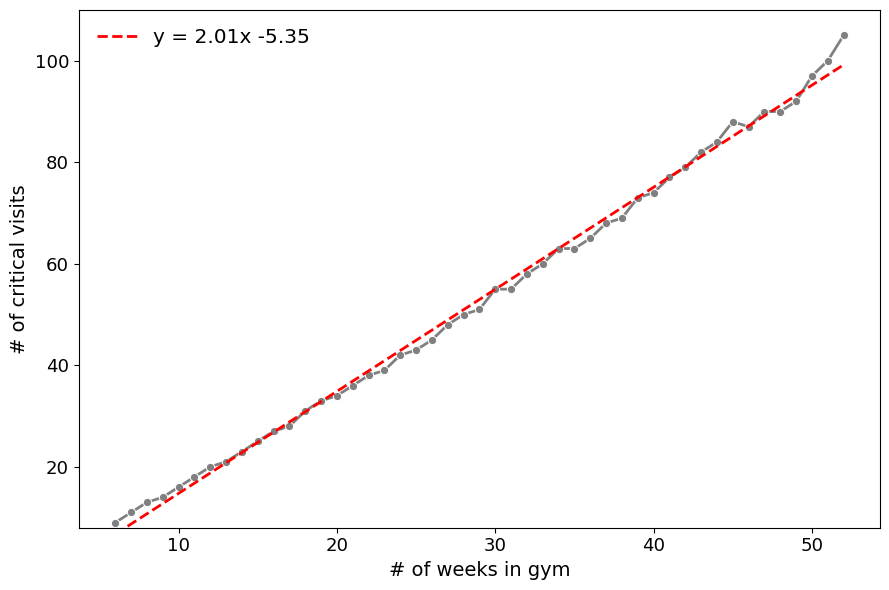

In [57]:
flags = []
for i in tqdm(range(6, 53)):    
    left_side = cstmr[cstmr["0_WEEKS_SURVIVAL_GRACE_DAY"] <= i]
    right_side = cstmr[cstmr["0_WEEKS_SURVIVAL_GRACE_DAY"] > i]

    temp1 = []
    temp2 = []
    for visit in range(1, 7*i+1):
        temp1.append(len(left_side[left_side["VISITS_"+str(i)+"_WEEKS"] >= visit]) / len(left_side))
        temp2.append(len(right_side[right_side["VISITS_"+str(i)+"_WEEKS"] >= visit]) / len(right_side))

    difference = np.array(temp2) - np.array(temp1)
    max_diff = round(max(difference), 2)
    max_diff_index = np.argmax(difference)
    flags.append(max_diff_index)

# Data for plotting
x = np.array([i for i in range(6, 53)])
y = np.array(flags)

# Fit linear regression model
m, n = np.polyfit(x, y, 1)
y_fit = m * x + n

# Plot the data points and the fitted line
plt.figure(figsize=(9, 6))
sns.lineplot(x=x, y=y, marker='o', color='gray', linestyle='-', linewidth=2)
sns.lineplot(x=x, y=y_fit, color='red', linestyle='--', linewidth=2, label=f'y = {m:.2f}x {n:.2f}')

# Add axis labels
plt.xlabel('# of weeks in gym', fontsize=14)
plt.ylabel('# of critical visits', fontsize=14)

# Set x-ticks and y-ticks with larger fonts
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Set limits for y-axis
plt.ylim(8, 110)

# Add legend
plt.legend(fontsize=14.5, title_fontsize=14.5, frameon=False, loc='upper left')

# Show plot
plt.tight_layout()
#plt.savefig("Fig_3_d_critical_visits.png", dpi=350)
plt.show()

# Export aggregated data
aggregated_data = pd.DataFrame({
    'Week': x,
    'Critical_Visits': y
})
aggregated_data.to_csv("Figures Data/Fig_3_d_critical_visits.csv", index=False)


### Fig 4(a,b)

In [ ]:
file_path = "dowhy-tests-master-june22.csv"
data = pd.read_csv(file_path)

morning_data = pd.read_csv("dowhy-tests-june22_SABAH.csv")
afternoon_data = pd.read_csv("dowhy-tests-june22_IKINDI.csv")
evening_data = pd.read_csv("dowhy-tests-june22_AKSAM.csv")
night_data = pd.read_csv("dowhy-tests-june22_GECE.csv")
noon_data = pd.read_csv("dowhy-tests-june22_OGLEN.csv")
master_data = pd.read_csv("dowhy-tests-master-june22.csv")

activity_levels = [0, 1, 2, 3]
time_periods = {
    "Morning": morning_data,
    "Afternoon": afternoon_data,
    "Evening": evening_data,
    "Night": night_data,
    "Noon": noon_data,
}

/var/folders/17/84mtmcxx0ps55c3xtvd0kjyw0000gn/T/ipykernel_60564/1450739978.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = data.pivot("column", "flag", "estimated_effect")


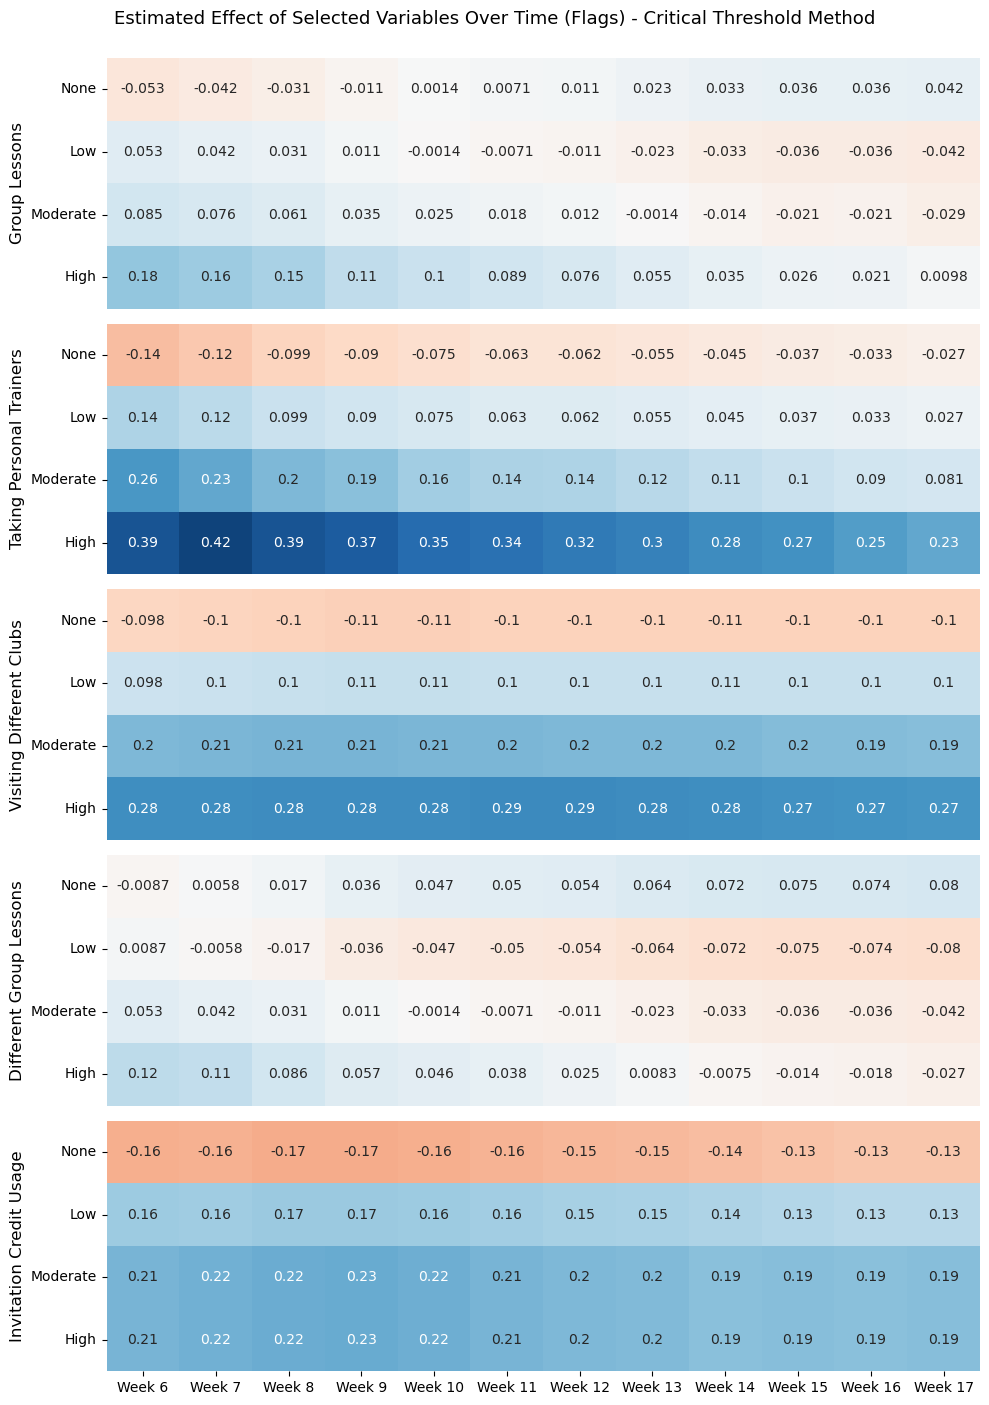

In [ ]:
heatmap_data = data.pivot("column", "flag", "estimated_effect")

columns_groups = [
    [
        "GROUP_LESSONS_6_WEEKS_0",
        "GROUP_LESSONS_6_WEEKS_1",
        "GROUP_LESSONS_6_WEEKS_2",
        "GROUP_LESSONS_6_WEEKS_3",
    ],
    ["PT_6_WEEKS_0", "PT_6_WEEKS_1", "PT_6_WEEKS_2", "PT_6_WEEKS_3"],
    ["DIFF_VST_6_0", "DIFF_VST_6_1", "DIFF_VST_6_2", "DIFF_VST_6_3"],
    [
        "DIFF_GROUP_LESSON_6_0",
        "DIFF_GROUP_LESSON_6_1",
        "DIFF_GROUP_LESSON_6_2",
        "DIFF_GROUP_LESSON_6_3",
    ],
    ["CREDIT_6_WEEKS_0", "CREDIT_6_WEEKS_1", "CREDIT_6_WEEKS_2", "CREDIT_6_WEEKS_3"],
]

flags_order_corrected_real_critical = [f"Flag_{i}" for i in range(6, 18)]

y_labels_groups = [
    ["None", "Low", "Moderate", "High"],
    ["None", "Low", "Moderate", "High"],
    ["None", "Low", "Moderate", "High"],
    ["None", "Low", "Moderate", "High"],
    ["None", "Low", "Moderate", "High"],
]

ax_list = [
    "Group Lessons",
    "Taking Personal Trainers",
    "Visiting Different Clubs",
    "Different Group Lessons",
    "Invitation Credit Usage",
]

file_names = [
    "GroupLessons",
    "TakingPersonalTrainers",
    "VisitingDifferentClubs",
    "DifferentGroupLessons",
    "InvitationCreditUsage",
]

x_labels = [f"Week {i}" for i in range(6, 18)]

fig, axes = plt.subplots(nrows=len(columns_groups), figsize=(10, 14))
for i, (ax, columns, y_labels) in enumerate(zip(axes, columns_groups, y_labels_groups)):
    heatmap_data_subset = heatmap_data.reindex(
        index=columns, columns=flags_order_corrected_real_critical
    )
    sns.heatmap(
        heatmap_data_subset,
        annot=True,
        cmap="RdBu",
        yticklabels=y_labels,
        xticklabels=x_labels,
        vmin=-0.45,
        vmax=0.45,
        ax=ax,
        cbar=False,
    )
    if i < 4:
        ax.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

    ax.set_xlabel("")
    ax.set_ylabel(ax_list[i], fontsize=12)

axes[-1].set_xlabel("")
fig.suptitle(
    "Estimated Effect of Selected Variables Over Time (Flags) - Critical Threshold Method",
    y=1.0,
    fontsize=13,
)
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.savefig("critical_threshold_final.png", dpi=1000, bbox_inches="tight")
plt.show()

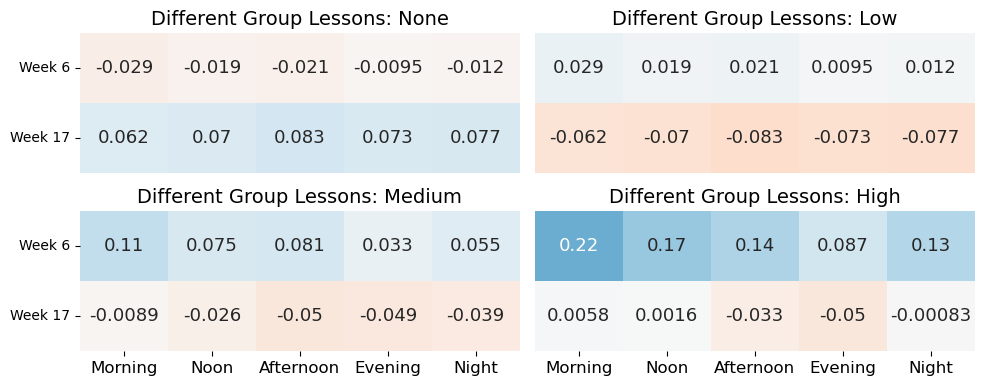

In [ ]:
def filter_activity_level(data, level):
    return data[data["column"].str.contains(f"DIFF_GROUP_LESSON_6_{level}")]


def prepare_heatmap_data(activity_level, flags):
    heatmap_data = pd.DataFrame(index=flags, columns=time_periods.keys())
    for period, data in time_periods.items():
        filtered_data = filter_activity_level(data, activity_level)
        filtered_data = filtered_data[["flag", "estimated_effect"]]
        filtered_data["flag"] = pd.Categorical(
            filtered_data["flag"], categories=flags, ordered=True
        )
        filtered_data = filtered_data[filtered_data["flag"].isin(flags)].sort_values(
            "flag"
        )
        heatmap_data[period] = filtered_data.set_index("flag")["estimated_effect"]
    return heatmap_data.astype(float)


flags_to_include = ["Flag_6", "Flag_17"]
y_labels = [f"Week {i}" for i in [6, 17]]

fig, axes = plt.subplots(2, 2, figsize=(10, 4))
axes = axes.flatten()

liste = ["None", "Low", "Medium", "High"]
order = ["Morning", "Noon", "Afternoon", "Evening", "Night"]
for i, level in enumerate(activity_levels):
    heatmap_data = prepare_heatmap_data(level, flags_to_include)
    heatmap_data = heatmap_data[["Morning", "Noon", "Afternoon", "Evening", "Night"]]
    heatmap_data.to_csv("diffGroupLessons_individualCluster_6_17.csv")
    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,
        cmap="RdBu",
        vmin=-0.45,
        vmax=0.45,
        cbar=False,
        yticklabels=y_labels if i % 2 == 0 else False,
        annot_kws={"fontsize": 13},
    )
    axes[i].set_title(f"Different Group Lessons: {liste[i]}", fontsize=14)
    axes[i].set_xticklabels(order, rotation=0, fontsize=12)
    if i < 2:
        axes[i].tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

for i in range(2):
    axes[i * 2].set_yticklabels(y_labels, rotation=0)


plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig("heatmap_final_diffgroup.pdf", dpi=500, bbox_inches="tight")
plt.show()

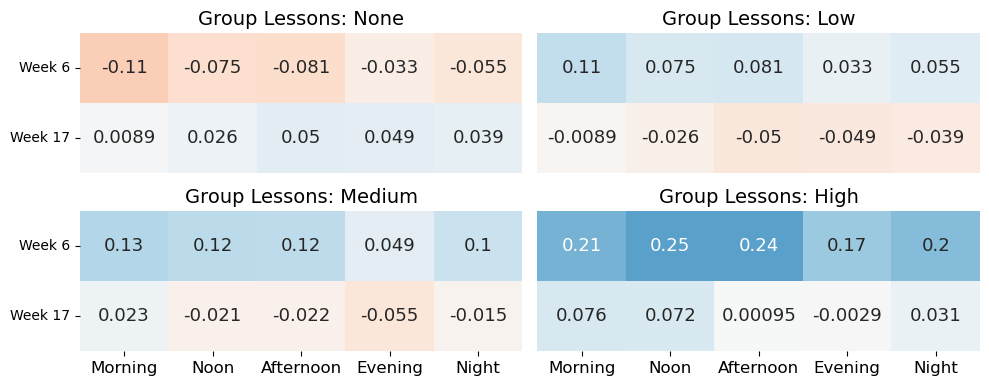

In [ ]:
def filter_activity_level(data, level):
    return data[data["column"].str.contains(f"GROUP_LESSONS_6_WEEKS_{level}")]


activity_levels = [0, 1, 2, 3]
time_periods = {
    "Morning": morning_data,
    "Afternoon": afternoon_data,
    "Evening": evening_data,
    "Night": night_data,
    "Noon": noon_data,
}


def prepare_heatmap_data(activity_level, flags):
    heatmap_data = pd.DataFrame(index=flags, columns=time_periods.keys())
    for period, data in time_periods.items():
        filtered_data = filter_activity_level(data, activity_level)
        filtered_data = filtered_data[["flag", "estimated_effect"]]
        filtered_data["flag"] = pd.Categorical(
            filtered_data["flag"], categories=flags, ordered=True
        )
        filtered_data = filtered_data[filtered_data["flag"].isin(flags)].sort_values(
            "flag"
        )
        heatmap_data[period] = filtered_data.set_index("flag")["estimated_effect"]
    return heatmap_data.astype(float)


flags_to_include = ["Flag_6", "Flag_17"]
y_labels = [f"Week {i}" for i in [6, 17]]

fig, axes = plt.subplots(2, 2, figsize=(10, 4))
axes = axes.flatten()

liste = ["None", "Low", "Medium", "High"]
order = ["Morning", "Noon", "Afternoon", "Evening", "Night"]
for i, level in enumerate(activity_levels):
    heatmap_data = prepare_heatmap_data(level, flags_to_include)
    heatmap_data = heatmap_data[["Morning", "Noon", "Afternoon", "Evening", "Night"]]
    heatmap_data.to_csv("groupLessons_individualCluster_6_17.csv")
    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,
        cmap="RdBu",
        vmin=-0.45,
        vmax=0.45,
        cbar=False,
        yticklabels=y_labels if i % 2 == 0 else False,
        annot_kws={"fontsize": 13},
    )
    axes[i].set_title(f"Group Lessons: {liste[i]}", fontsize=14)
    axes[i].set_xticklabels(order, rotation=0, fontsize=12)
    if i < 2:
        axes[i].tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )


for i in range(2):
    axes[i * 2].set_yticklabels(y_labels, rotation=0)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig("heatmap_final_group.pdf", dpi=500, bbox_inches="tight")
plt.show()

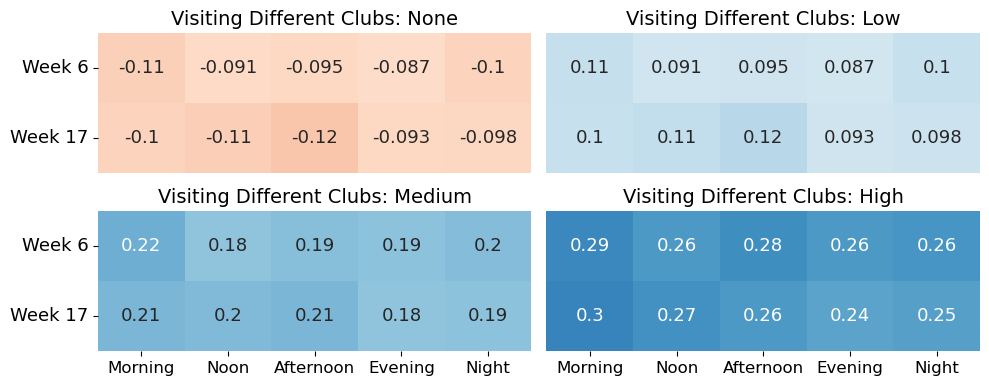

In [ ]:
def filter_activity_level(data, level):
    return data[data["column"].str.contains(f"DIFF_VST_6_{level}")]


activity_levels = [0, 1, 2, 3]
time_periods = {
    "Morning": morning_data,
    "Afternoon": afternoon_data,
    "Evening": evening_data,
    "Night": night_data,
    "Noon": noon_data,
}


def prepare_heatmap_data(activity_level, flags):
    heatmap_data = pd.DataFrame(index=flags, columns=time_periods.keys())
    for period, data in time_periods.items():
        filtered_data = filter_activity_level(data, activity_level)
        filtered_data = filtered_data[["flag", "estimated_effect"]]
        filtered_data["flag"] = pd.Categorical(
            filtered_data["flag"], categories=flags, ordered=True
        )
        filtered_data = filtered_data[filtered_data["flag"].isin(flags)].sort_values(
            "flag"
        )
        heatmap_data[period] = filtered_data.set_index("flag")["estimated_effect"]
    return heatmap_data.astype(float)


flags_to_include = ["Flag_6", "Flag_17"]
y_labels = [f"Week {i}" for i in [6, 17]]

fig, axes = plt.subplots(2, 2, figsize=(10, 4))
axes = axes.flatten()

liste = ["None", "Low", "Medium", "High"]
order = ["Morning", "Noon", "Afternoon", "Evening", "Night"]
for i, level in enumerate(activity_levels):
    heatmap_data = prepare_heatmap_data(level, flags_to_include)
    heatmap_data = heatmap_data[["Morning", "Noon", "Afternoon", "Evening", "Night"]]
    heatmap_data.to_csv("diffClub_individualCluster_6_17.csv")
    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,
        cmap="RdBu",
        vmin=-0.45,
        center=0,
        vmax=0.45,
        cbar=False,
        yticklabels=y_labels if i % 2 == 0 else False,
        annot_kws={"fontsize": 13},
    )
    axes[i].set_title(f"Visiting Different Clubs: {liste[i]}", fontsize=14)
    axes[i].set_xticklabels(order, rotation=0, fontsize=12)
    if i < 2:
        axes[i].tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )


for i in range(2):
    axes[i * 2].set_yticklabels(y_labels, rotation=0, fontsize=13)


plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig("heatmap_final_diffclub.pdf", dpi=500, bbox_inches="tight")
plt.show()

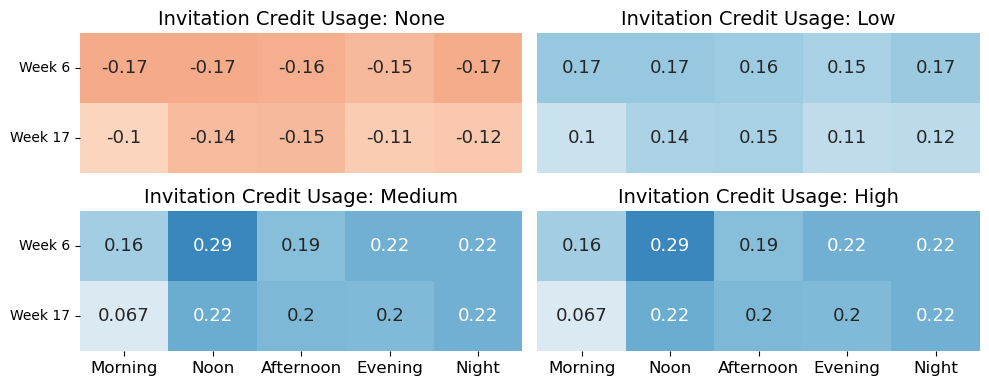

In [ ]:
def filter_activity_level(data, level):
    return data[data["column"].str.contains(f"CREDIT_6_WEEKS_{level}")]


activity_levels = [0, 1, 2, 3]
time_periods = {
    "Morning": morning_data,
    "Afternoon": afternoon_data,
    "Evening": evening_data,
    "Night": night_data,
    "Noon": noon_data,
}


def prepare_heatmap_data(activity_level, flags):
    heatmap_data = pd.DataFrame(index=flags, columns=time_periods.keys())
    for period, data in time_periods.items():
        filtered_data = filter_activity_level(data, activity_level)
        filtered_data = filtered_data[["flag", "estimated_effect"]]
        filtered_data["flag"] = pd.Categorical(
            filtered_data["flag"], categories=flags, ordered=True
        )
        filtered_data = filtered_data[filtered_data["flag"].isin(flags)].sort_values(
            "flag"
        )
        heatmap_data[period] = filtered_data.set_index("flag")["estimated_effect"]
    return heatmap_data.astype(float)


flags_to_include = ["Flag_6", "Flag_17"]
y_labels = [f"Week {i}" for i in [6, 17]]

fig, axes = plt.subplots(2, 2, figsize=(10, 4))
axes = axes.flatten()

liste = ["None", "Low", "Medium", "High"]
order = ["Morning", "Noon", "Afternoon", "Evening", "Night"]
for i, level in enumerate(activity_levels):
    heatmap_data = prepare_heatmap_data(level, flags_to_include)
    heatmap_data = heatmap_data[["Morning", "Noon", "Afternoon", "Evening", "Night"]]
    heatmap_data.to_csv("invitationCredit_individualCluster_6_17.csv")
    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,
        cmap="RdBu",
        vmin=-0.45,
        center=0,
        vmax=0.45,
        cbar=False,
        yticklabels=y_labels if i % 2 == 0 else False,
        annot_kws={"fontsize": 13},
    )
    axes[i].set_title(f"Invitation Credit Usage: {liste[i]}", fontsize=14)
    axes[i].set_xticklabels(order, rotation=0, fontsize=12)
    if i < 2:
        axes[i].tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )


for i in range(2):
    axes[i * 2].set_yticklabels(y_labels, rotation=0)


plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig("heatmap_final_credit.pdf", dpi=500, bbox_inches="tight")
plt.show()

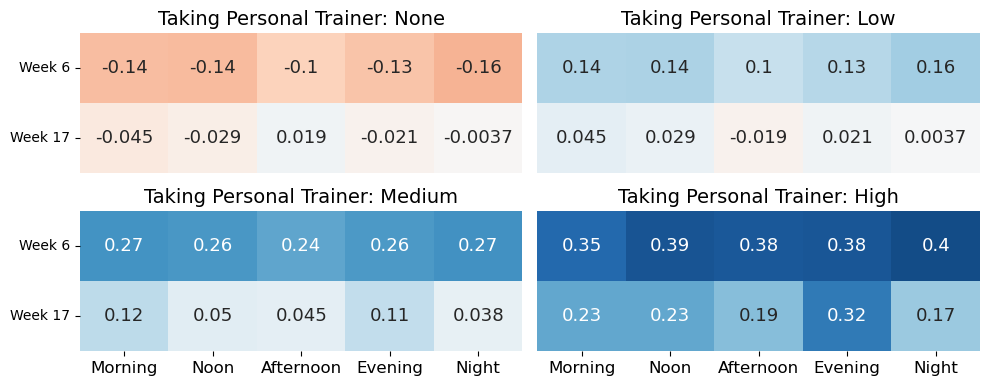

In [ ]:
def filter_activity_level(data, level):
    return data[data["column"].str.contains(f"PT_6_WEEKS_{level}")]


activity_levels = [0, 1, 2, 3]
time_periods = {
    "Morning": morning_data,
    "Afternoon": afternoon_data,
    "Evening": evening_data,
    "Night": night_data,
    "Noon": noon_data,
}


def prepare_heatmap_data(activity_level, flags):
    heatmap_data = pd.DataFrame(index=flags, columns=time_periods.keys())
    for period, data in time_periods.items():
        filtered_data = filter_activity_level(data, activity_level)
        filtered_data = filtered_data[["flag", "estimated_effect"]]
        filtered_data["flag"] = pd.Categorical(
            filtered_data["flag"], categories=flags, ordered=True
        )
        filtered_data = filtered_data[filtered_data["flag"].isin(flags)].sort_values(
            "flag"
        )
        heatmap_data[period] = filtered_data.set_index("flag")["estimated_effect"]
    return heatmap_data.astype(float)


flags_to_include = ["Flag_6", "Flag_17"]
y_labels = [f"Week {i}" for i in [6, 17]]

fig, axes = plt.subplots(2, 2, figsize=(10, 4))
axes = axes.flatten()

liste = ["None", "Low", "Medium", "High"]
order = ["Morning", "Noon", "Afternoon", "Evening", "Night"]
for i, level in enumerate(activity_levels):
    heatmap_data = prepare_heatmap_data(level, flags_to_include)
    heatmap_data = heatmap_data[["Morning", "Noon", "Afternoon", "Evening", "Night"]]
    heatmap_data.to_csv("personalTrainer_individualCluster_6_17.csv")
    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,
        cmap="RdBu",
        vmin=-0.45,
        center=0,
        vmax=0.45,
        cbar=False,
        yticklabels=y_labels if i % 2 == 0 else False,
        annot_kws={"fontsize": 13},
    )
    axes[i].set_title(f"Taking Personal Trainer: {liste[i]}", fontsize=14)
    axes[i].set_xticklabels(order, rotation=0, fontsize=12)
    if i < 2:
        axes[i].tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )


for i in range(2):
    axes[i * 2].set_yticklabels(y_labels, rotation=0)


plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig("heatmap_final_pt.pdf", dpi=500, bbox_inches="tight")
plt.show()

### Fig5

/var/folders/17/84mtmcxx0ps55c3xtvd0kjyw0000gn/T/ipykernel_60564/1305087267.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = data.pivot("column", "flag", "estimated_effect")


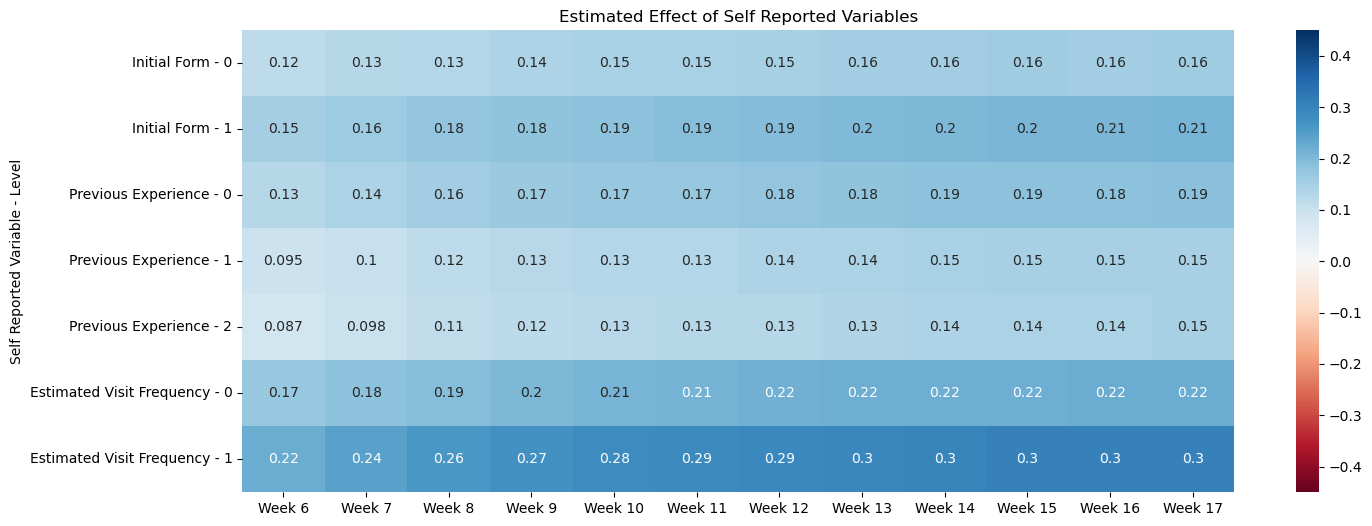

In [ ]:
file_path = "dowhy-tests-gtkb-june22.csv"
data = pd.read_csv(file_path)

heatmap_data = data.pivot("column", "flag", "estimated_effect")

columns_order_corrected_real_gtkb = [
    "FORM>10",
    "FORM>30",
    "TECRUBE>0",
    "TECRUBE>1",
    "TECRUBE>2",
    "SIKLIK>1",
    "SIKLIK>2",
]

flags_order_corrected_real_gtkb = [f"Flag_{i}" for i in range(6, 18)]

heatmap_data_corrected_real_gtkb = heatmap_data.reindex(
    index=columns_order_corrected_real_gtkb, columns=flags_order_corrected_real_gtkb
)

heatmap_data_corrected_real_gtkb.to_csv("gtkb_heatmap_data.csv")

y_labels = [
    "Initial Form - 0",
    "Initial Form - 1",
    "Previous Experience - 0",
    "Previous Experience - 1",
    "Previous Experience - 2",
    "Estimated Visit Frequency - 0",
    "Estimated Visit Frequency - 1",
]

x_labels = [f"Week {i}" for i in range(6, 18)]

plt.figure(figsize=(16, 6))
ax = sns.heatmap(
    heatmap_data_corrected_real_gtkb,
    annot=True,
    cmap="RdBu",
    yticklabels=y_labels,
    xticklabels=x_labels,
    vmin=-0.45,
    vmax=0.45,
)

ax.set_ylabel("Self Reported Variable - Level")
ax.set_xlabel("")
ax.set_title("Estimated Effect of Self Reported Variables")

plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.savefig("gtkb.pdf", dpi=500, bbox_inches="tight")

plt.show()

## Figure 6

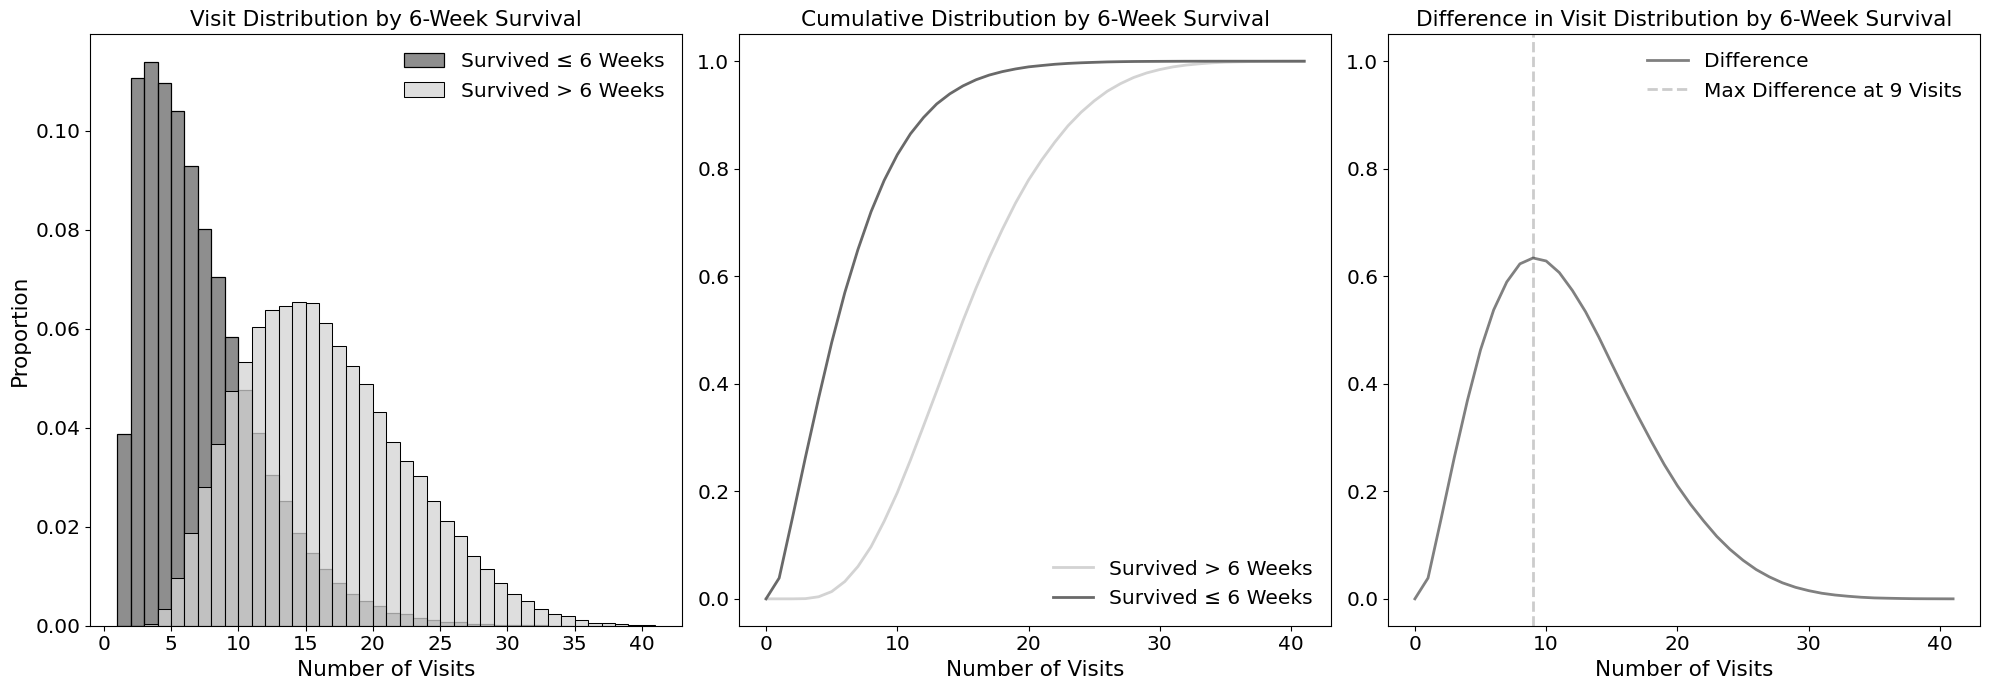

In [59]:
i = 6
class_1 = cstmr[cstmr["0_WEEKS_SURVIVAL_GRACE_DAY"] <= i]
class_2 = cstmr[cstmr["0_WEEKS_SURVIVAL_GRACE_DAY"] > i]

# Create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
label_fontsize = 15.5
tick_fontsize = 14.5
legend_fontsize = 14.5

# Combined histogram for Survived ≤ 6 Weeks and Survived > 6 Weeks
sns.histplot(ax=axs[0], data=class_1, x=f'VISITS_{i}_WEEKS', binwidth=1, stat='probability', color="dimgray", label=f'Survived ≤ {i} Weeks')
sns.histplot(ax=axs[0], data=class_2, x=f'VISITS_{i}_WEEKS', binwidth=1, stat='probability', color="lightgray", label=f'Survived > {i} Weeks')
axs[0].set_title(f'Visit Distribution by {i}-Week Survival', fontsize=label_fontsize)
axs[0].set_xlabel('Number of Visits', fontsize=label_fontsize)
axs[0].set_ylabel('Proportion', fontsize=label_fontsize)
axs[0].xaxis.set_tick_params(labelsize=tick_fontsize)
axs[0].yaxis.set_tick_params(labelsize=tick_fontsize)
axs[0].legend(fontsize=legend_fontsize, frameon=False)

# Cumulative distribution plot
temp1 = []
temp2 = []
for visit in range(1, 7*i+1):
    temp1.append(len(class_1[class_1[f"VISITS_{i}_WEEKS"] < visit]) / len(class_1))
    temp2.append(len(class_2[class_2[f"VISITS_{i}_WEEKS"] < visit]) / len(class_2))

sns.lineplot(x=range(len(temp2)), y=temp2, color='lightgray', label=f"Survived > {i} Weeks", ax=axs[1], linewidth=2)
sns.lineplot(x=range(len(temp1)), y=temp1, color='dimgray', label=f"Survived ≤ {i} Weeks", ax=axs[1], linewidth=2)
axs[1].set_xlabel('Number of Visits', fontsize=label_fontsize)
axs[1].set_title(f"Cumulative Distribution by {i}-Week Survival", fontsize=label_fontsize)
axs[1].legend(fontsize=legend_fontsize, frameon=False)
axs[1].xaxis.set_tick_params(labelsize=tick_fontsize)
axs[1].yaxis.set_tick_params(labelsize=tick_fontsize)

# Difference plot
difference = np.array(temp1) - np.array(temp2)
max_diff_index = np.argmax(difference)

axs[2].plot(range(len(difference)), difference, color='gray', label='Difference', linewidth=2)
axs[2].axvline(x=max_diff_index, color='black', linestyle='--', alpha=0.2, linewidth=2, label=f'Max Difference at {max_diff_index} Visits')
axs[2].set_xlabel('Number of Visits', fontsize=label_fontsize)
axs[2].set_title(f"Difference in Visit Distribution by {i}-Week Survival", fontsize=label_fontsize)
axs[2].legend(fontsize=legend_fontsize, frameon=False)
axs[2].xaxis.set_tick_params(labelsize=tick_fontsize)
axs[2].yaxis.set_tick_params(labelsize=tick_fontsize)
axs[2].sharey(axs[1])

# Adjust layout to prevent overlapping and make it visually appealing
plt.tight_layout()

# Save the figure
#plt.savefig(f"Fig_6_Estimating_critical_number_of_visits.png", dpi=350)

# Export aggregated data
aggregated_data = pd.DataFrame({
    'Number of Visits': range(1, 7*i+1),
    'Cumulative Proportion (Survived ≤ 6 Weeks)': temp1,
    'Cumulative Proportion (Survived > 6 Weeks)': temp2,
    'Difference': difference
})
aggregated_data.to_csv("Figures Data/Fig_6_Estimating_critical_number_of_visits.csv", index=False)

plt.show()

### Appendix A

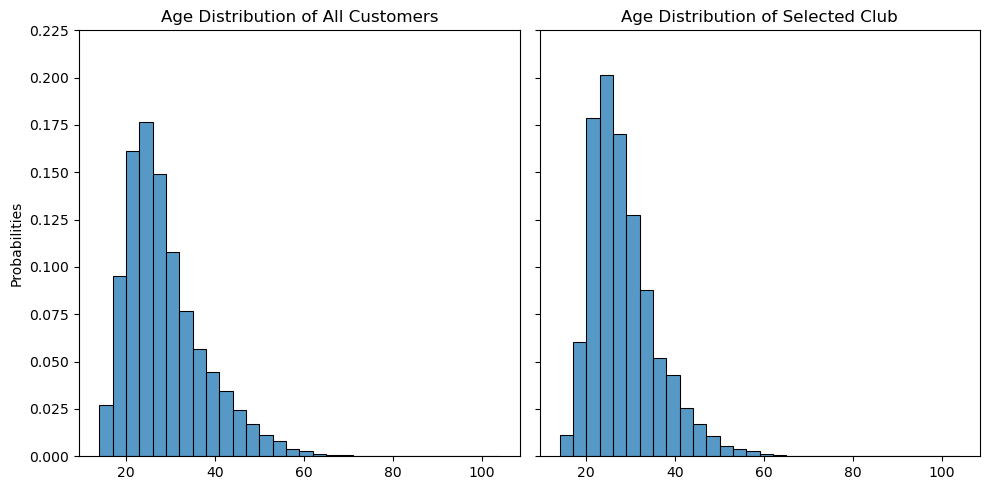

In [86]:
# Shared bin settings
cstmr = pd.read_csv(DATA_PREFIX + "cstmr_june_22_dowhy.csv")
vsts = pd.read_csv(DATA_PREFIX + "all_vsts_202401.csv")

users = list(cstmr.USER_ID)

vsts = vsts[vsts["USER_ID"].isin(users)]
trump_cst = cstmr[cstmr["CLUB_ID"] == 51]

binwidth = 3
min_age = min(cstmr["AGE"].min(), trump_cst["AGE"].min())
max_age = max(cstmr["AGE"].max(), trump_cst["AGE"].max())

# Adjust max_age to ensure the final bin includes the max value
max_age = binwidth * (int(np.ceil(max_age / binwidth)) + 1)

bin_edges = np.arange(min_age, max_age + binwidth, binwidth)

# Create the plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
hist1 = sns.histplot(ax=ax[0], data=cstmr, x="AGE", bins=bin_edges, stat="probability")
hist2 = sns.histplot(
    ax=ax[1], data=trump_cst, x="AGE", bins=bin_edges, stat="probability"
)

# Labels and layout
ax[0].set_title("Age Distribution of All Customers")
ax[0].set_ylabel("Probabilities")
ax[1].set_title("Age Distribution of Selected Club")
ax[1].set_ylabel("")
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[0].set_ylim(0, 0.225)
plt.tight_layout()
plt.show()


# Function to extract histogram data
def extract_histogram_data(ax, filename):
    bins = []
    heights = []

    for patch in ax.patches:
        x = patch.get_x()
        width = patch.get_width()
        height = patch.get_height()
        bins.append((x, x + width))
        heights.append(height)

    df = pd.DataFrame(
        {
            "bin_start": [b[0] for b in bins],
            "bin_end": [b[1] for b in bins],
            "probability": heights,
        }
    )

    df.to_csv(filename, index=False)


# Save CSVs
extract_histogram_data(hist1.axes, "all_customers_age_distribution.csv")
extract_histogram_data(hist2.axes, "selected_club_age_distribution.csv")

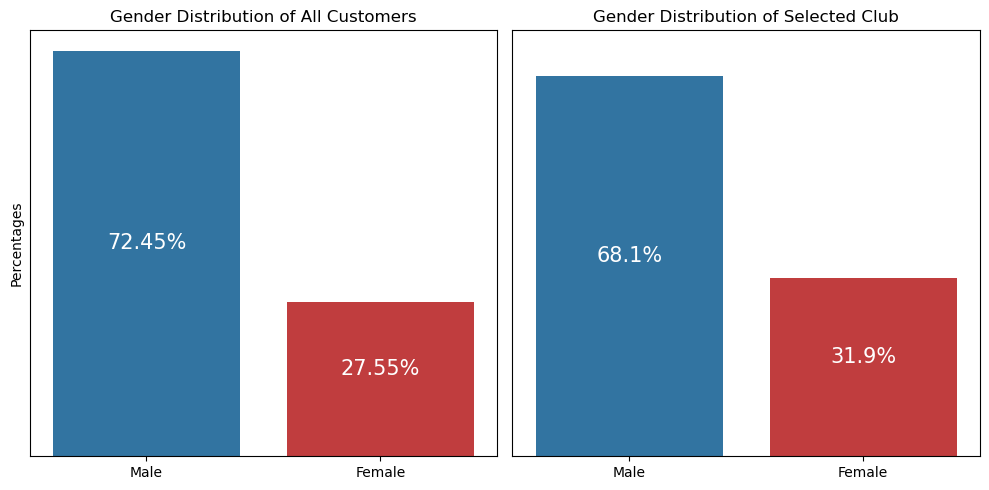

In [87]:
palette = sns.color_palette()

p = {"Male": palette[0], "Female": palette[3]}

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
sns.countplot(ax=axs[0], data=cstmr, x="SEX", palette=p)
sns.countplot(ax=axs[1], data=trump_cst, x="SEX", palette=p)
axs[0].set_title("Gender Distribution of All Customers")
axs[0].set_ylabel("Percentages")
axs[1].set_title("Gender Distribution of Selected Club")
axs[1].set_ylabel("")
axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[0].set_yticks([])
axs[1].set_yticks([])
axs[1].set_ylim(0, 3500)

tot = [len(cstmr), len(trump_cst)]

for i, ax in enumerate(axs):
    for patch in ax.patches:
        height = patch.get_height()
        perc = round((height / tot[i]) * 100, 2)
        ax.annotate(
            f"{perc}%",
            (patch.get_x() + patch.get_width() / 2, height / 2),
            ha="center",
            va="bottom",
            fontsize=15,
            color="white",
        )


plt.tight_layout()
plt.show()
# plt.savefig("/Users/efetuzun/Downloads/all_vs_x_club_gender.pdf", dpi=800)

### Appendix E

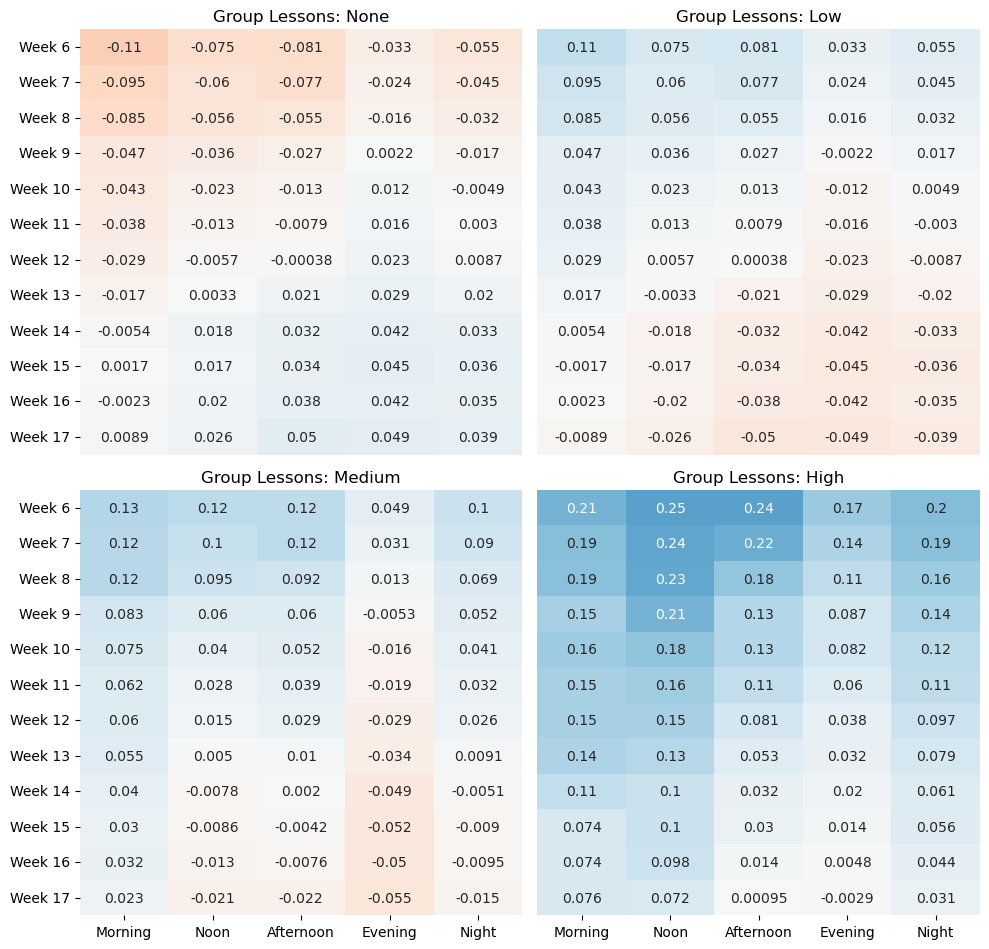

In [ ]:
def filter_activity_level(data, level):
    return data[data["column"].str.contains(f"GROUP_LESSONS_6_WEEKS_{level}")]


def prepare_heatmap_data(activity_level):
    heatmap_data = pd.DataFrame(
        index=flags_order_corrected_real_critical, columns=time_periods.keys()
    )
    for period, data in time_periods.items():
        filtered_data = filter_activity_level(data, activity_level)
        filtered_data = filtered_data[["flag", "estimated_effect"]]
        filtered_data["flag"] = pd.Categorical(
            filtered_data["flag"],
            categories=flags_order_corrected_real_critical,
            ordered=True,
        )
        filtered_data = filtered_data.sort_values("flag")
        heatmap_data[period] = filtered_data.set_index("flag")["estimated_effect"]
    return heatmap_data.astype(float)


activity_levels = [0, 1, 2, 3]
time_periods = {
    "Morning": morning_data,
    "Afternoon": afternoon_data,
    "Evening": evening_data,
    "Night": night_data,
    "Noon": noon_data,
}

flags_order_corrected_real_critical = [f"Flag_{i}" for i in range(6, 18)]
y_labels = [f"Week {i}" for i in range(6, 18)]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

liste = ["None", "Low", "Medium", "High"]
order = ["Morning", "Noon", "Afternoon", "Evening", "Night"]
for i, level in enumerate(activity_levels):
    heatmap_data = prepare_heatmap_data(level)
    heatmap_data = heatmap_data[["Morning", "Noon", "Afternoon", "Evening", "Night"]]
    heatmap_data.to_csv("groupLessons_individualCluster.csv")
    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,
        cmap="RdBu",
        vmin=-0.45,
        vmax=0.45,
        yticklabels=y_labels if i % 2 == 0 else False,
        cbar=False,
    )
    axes[i].set_title(f"Group Lessons: {liste[i]}")
    if i < 2:
        axes[i].tick_params(
            axis="both", which="both", bottom=False, top=False, labelbottom=False
        )


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("heatmap_ex_group.pdf", dpi=500, bbox_inches="tight")
plt.show()

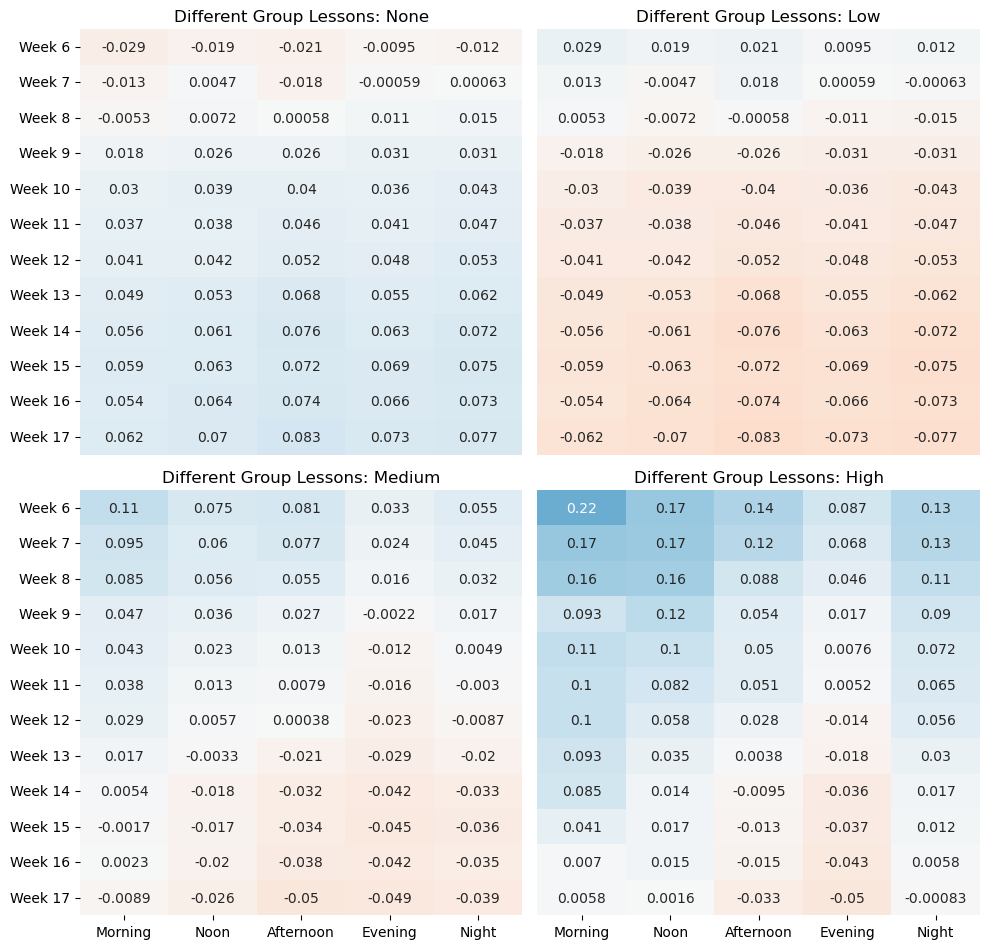

In [ ]:
def filter_activity_level(data, level):
    return data[data["column"].str.contains(f"DIFF_GROUP_LESSON_6_{level}")]


flags_order_corrected_real_critical = [f"Flag_{i}" for i in range(6, 18)]
y_labels = [f"Week {i}" for i in range(6, 18)]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

liste = ["None", "Low", "Medium", "High"]
order = ["Morning", "Noon", "Afternoon", "Evening", "Night"]
for i, level in enumerate(activity_levels):
    heatmap_data = prepare_heatmap_data(level)
    heatmap_data = heatmap_data[["Morning", "Noon", "Afternoon", "Evening", "Night"]]
    heatmap_data.to_csv("diffGroupLessons_individualCluster.csv")
    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,
        cmap="RdBu",
        vmin=-0.45,
        vmax=0.45,
        yticklabels=y_labels if i % 2 == 0 else False,
        cbar=False,
    )
    axes[i].set_title(f"Different Group Lessons: {liste[i]}")
    if i < 2:
        axes[i].tick_params(
            axis="both", which="both", bottom=False, top=False, labelbottom=False
        )


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("heatmap_ex_diffgroup.pdf", dpi=500, bbox_inches="tight")
plt.show()

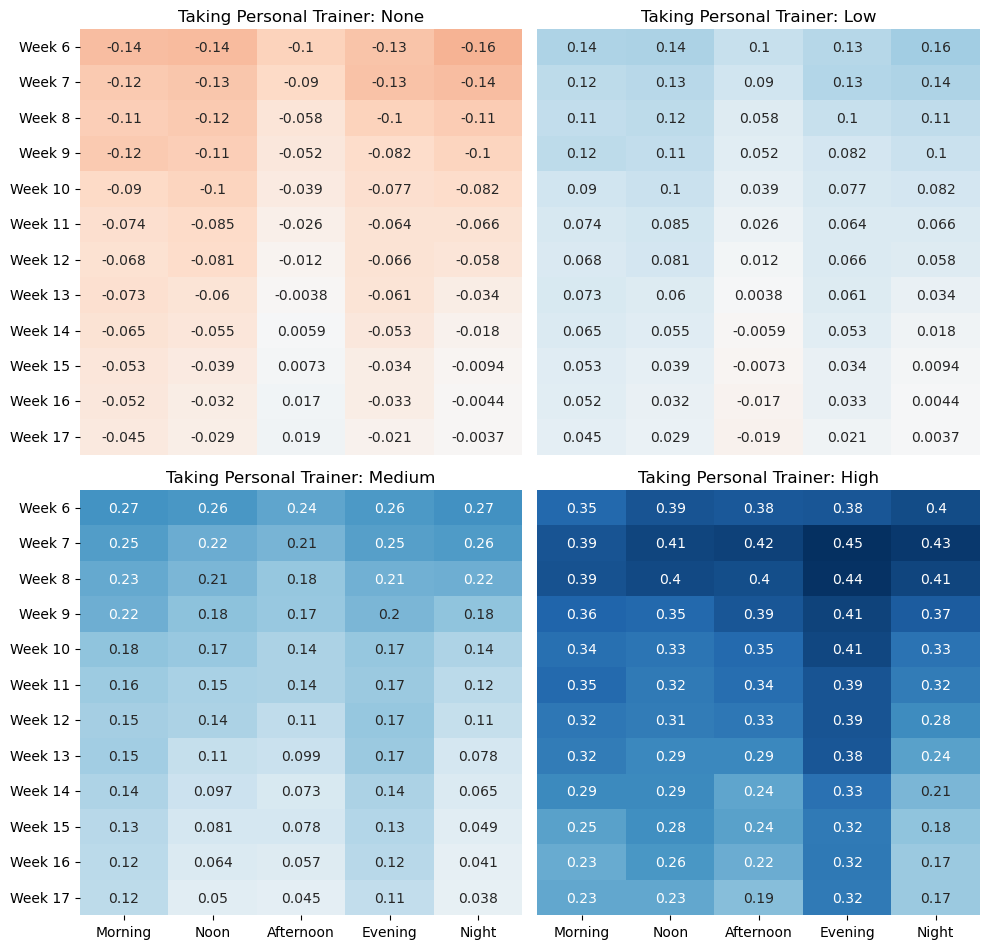

In [ ]:
def filter_activity_level(data, level):
    return data[data["column"].str.contains(f"PT_6_WEEKS_{level}")]


flags_order_corrected_real_critical = [f"Flag_{i}" for i in range(6, 18)]
y_labels = [f"Week {i}" for i in range(6, 18)]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

liste = ["None", "Low", "Medium", "High"]
order = ["Morning", "Noon", "Afternoon", "Evening", "Night"]
for i, level in enumerate(activity_levels):
    heatmap_data = prepare_heatmap_data(level)
    heatmap_data = heatmap_data[["Morning", "Noon", "Afternoon", "Evening", "Night"]]
    heatmap_data.to_csv("personalTrainer_individualCluster.csv")
    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,
        cmap="RdBu",
        vmin=-0.45,
        vmax=0.45,
        yticklabels=y_labels if i % 2 == 0 else False,
        cbar=False,
    )
    axes[i].set_title(f"Taking Personal Trainer: {liste[i]}")
    if i < 2:
        axes[i].tick_params(
            axis="both", which="both", bottom=False, top=False, labelbottom=False
        )


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("heatmap_ex_personalTrainer.pdf", dpi=500, bbox_inches="tight")
plt.show()

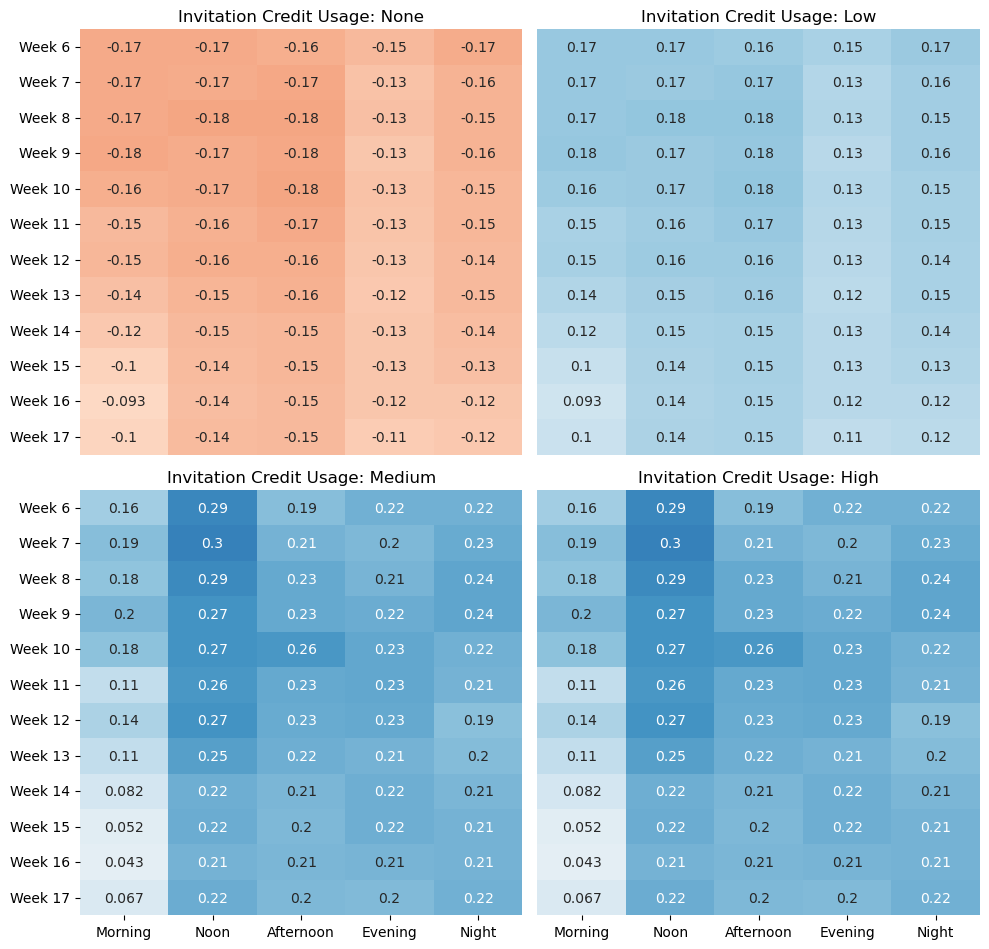

In [ ]:
def filter_activity_level(data, level):
    return data[data["column"].str.contains(f"CREDIT_6_WEEKS_{level}")]


flags_order_corrected_real_critical = [f"Flag_{i}" for i in range(6, 18)]
y_labels = [f"Week {i}" for i in range(6, 18)]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

liste = ["None", "Low", "Medium", "High"]
order = ["Morning", "Noon", "Afternoon", "Evening", "Night"]
for i, level in enumerate(activity_levels):
    heatmap_data = prepare_heatmap_data(level)
    heatmap_data = heatmap_data[["Morning", "Noon", "Afternoon", "Evening", "Night"]]
    heatmap_data.to_csv("invitationCredit_individualCluster.csv")
    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,
        cmap="RdBu",
        vmin=-0.45,
        vmax=0.45,
        yticklabels=y_labels if i % 2 == 0 else False,
        cbar=False,
    )
    axes[i].set_title(f"Invitation Credit Usage: {liste[i]}")
    if i < 2:
        axes[i].tick_params(
            axis="both", which="both", bottom=False, top=False, labelbottom=False
        )


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("heatmap_ex_credit.pdf", dpi=500, bbox_inches="tight")
plt.show()

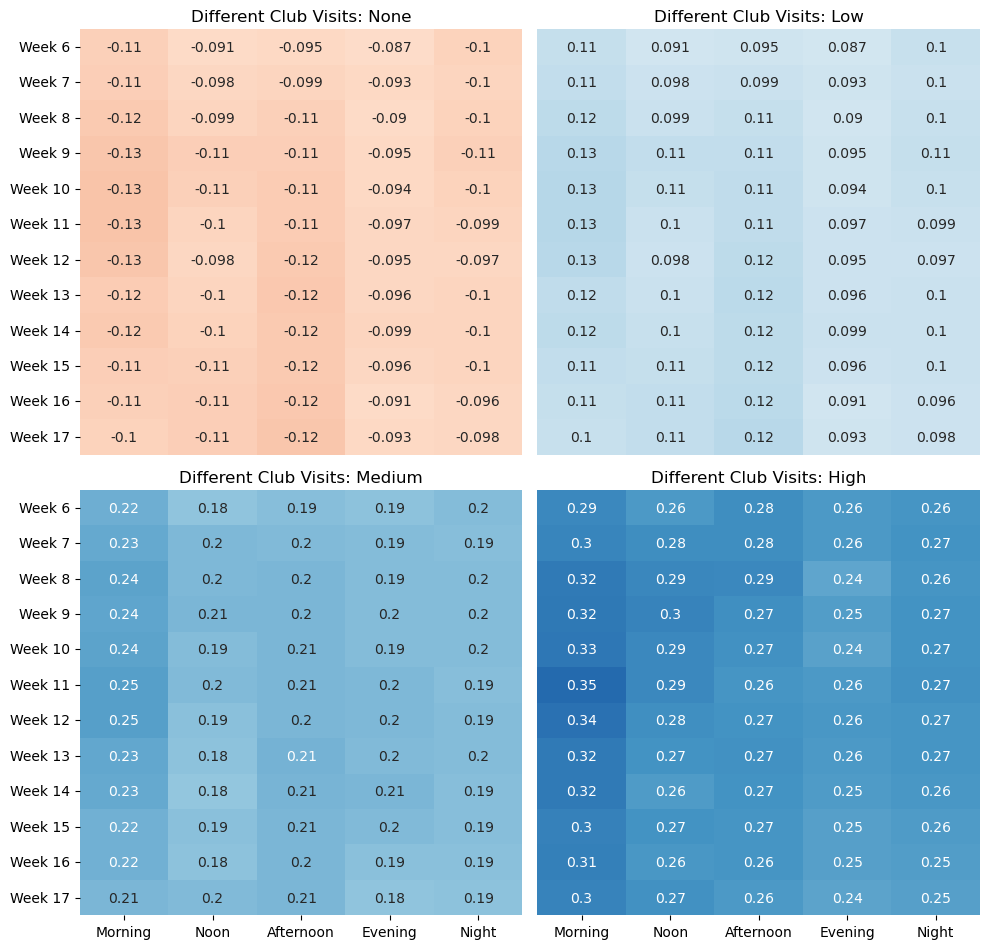

In [ ]:
def filter_activity_level(data, level):
    return data[data["column"].str.contains(f"DIFF_VST_6_{level}")]


flags_order_corrected_real_critical = [f"Flag_{i}" for i in range(6, 18)]
y_labels = [f"Week {i}" for i in range(6, 18)]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

liste = ["None", "Low", "Medium", "High"]
order = ["Morning", "Noon", "Afternoon", "Evening", "Night"]
for i, level in enumerate(activity_levels):
    heatmap_data = prepare_heatmap_data(level)
    heatmap_data = heatmap_data[["Morning", "Noon", "Afternoon", "Evening", "Night"]]
    heatmap_data.to_csv("diffClub_individualCluster.csv")
    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,
        cmap="RdBu",
        vmin=-0.45,
        vmax=0.45,
        yticklabels=y_labels if i % 2 == 0 else False,
        cbar=False,
    )
    axes[i].set_title(f"Different Club Visits: {liste[i]}")
    if i < 2:
        axes[i].tick_params(
            axis="both", which="both", bottom=False, top=False, labelbottom=False
        )


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("heatmap_ex_diffVst.pdf", dpi=500, bbox_inches="tight")
plt.show()